In [1]:
!pip install ogb

In [2]:
from torch_scatter import scatter_softmax, scatter_mean

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding, ModuleList
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_scatter import scatter, scatter_mean, scatter_add, scatter_sum
from torch_geometric.nn import GINConv, GINEConv


class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


class BondEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BondEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(3):
            self.embeddings.append(Embedding(6, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, edge_attr):
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(1)

        out = 0
        for i in range(edge_attr.size(1)):
            out += self.embeddings[i](edge_attr[:, i])
        return out


class Global_Gen_Sum_Mean_Max_Pool(nn.Module):
    def __init__(self, family = "softmax", p = 1.0, beta = 1.0, 
                 trainable_p = False, trainable_beta = False):
        r"""Performs batch-wise graph-level-outputs by transforming node
        features based on a Generalized Aggr-Mean-Max function, so that
        for a single graph :math:`\mathcal{G}_i` its output is computed
        deppending on the family of transformations by:
        .. math::
            \mathbf{r}_i = \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{softmax} \left( \mathbf{x}_n * p \right) * \mathbf{x}_n
        for softmax aggregation or
        .. math::
            \mathbf{r}_i = \left( \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{x}_n^{p} \right)^{1/p}
        for power mean aggregation.

        Args:
            family (str): family of generalized mean-max functions to use. 
                Either "softmax" or "power" for eq. 1 or eq. 2 respectively.
            p (float): parameter for the generalized mean-max function
            trainable (bool): whether the value of p is learnable during training.
        """
        super(Global_Gen_Sum_Mean_Max_Pool, self).__init__()
        
        self.family         = family
        self.base_p         = p
        self.base_beta      = beta
        self.trainable_p    = trainable_p
        self.trainable_beta = trainable_beta
        # define params
        self.p = torch.nn.Parameter(torch.tensor([p], device=device),
                                    requires_grad=trainable_p)# .to(device)
        self.beta = torch.nn.Parameter(torch.tensor([beta], device=device),
                                       requires_grad=trainable_beta)# .to(device)

    def forward(self, x, batch, bsize=None):
        r"""Args:
            x (Tensor): Node feature matrix
                :math:`\mathbf{X} \in \mathbb{R}^{(N_1 + \ldots + N_B) \times F}`.
            batch (LongTensor): Batch vector :math:`\mathbf{b} \in {\{ 0, \ldots,
                B-1\}}^N`, which assigns each node to a specific example.
            size (int, optional): Batch-size :math:`B`.
                Automatically calculated if not given. (default: :obj:`None`)
        :rtype: :class:`Tensor`
        """
        bsize = int(batch.max().item() + 1) if bsize is None else bsize
        n_nodes = scatter_sum(torch.ones_like(x), batch, dim=0, dim_size=bsize)
        if self.family == "softmax":
            out = scatter_softmax(self.p * x.detach(), batch, dim=0)
            return scatter_add(x * out,
                                batch, dim=0, dim_size=bsize)*n_nodes / (1+self.beta*(n_nodes-1))

        elif self.family == "power":
            # numerical stability - avoid powers of large numbers or negative ones
            min_x, max_x = 1e-7, 1e+3
            torch.clamp_(x, min_x, max_x)
            out = scatter_add(torch.pow(x, self.p),
                               batch, dim=0, dim_size=bsize) / (1+self.beta*(n_nodes-1))
            torch.clamp_(out, min_x, max_x)
            return torch.pow(out, 1 / self.p)


    def reset_parameters(self):
        if self.p and torch.is_tensor(self.p):
            self.p.data.fill_(self.base_p)
        if self.beta and torch.is_tensor(self.beta):
            self.beta.data.fill_(self.base_beta)


    def __repr__(self):
        return "Generalized Aggr-Mean-Max global pooling layer with params:" + \
               str({"family": self.family,
                    "base_p": self.base_p,
                    "base_beta"     : self.base_beta,
                    "trainable_p"   : self.trainable_p,
                    "trainable_beta": self.trainable_beta})



class Net(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, dropout=0.0,
                 inter_message_passing=True):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.inter_message_passing = inter_message_passing

        self.atom_encoder = AtomEncoder(hidden_channels)
        self.clique_encoder = Embedding(4, hidden_channels)

        self.bond_encoders = ModuleList()
        self.atom_convs = ModuleList()
        self.atom_batch_norms = ModuleList()
        self.reader = Global_Gen_Sum_Mean_Max_Pool(family = "softmax", p = 1e-5, beta = 1e-5, 
                                                   trainable_p = True, trainable_beta = True)

        for _ in range(num_layers):
            self.bond_encoders.append(BondEncoder(hidden_channels))
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.atom_convs.append(GINEConv(nn, train_eps=True))
            self.atom_batch_norms.append(BatchNorm1d(hidden_channels))

        self.clique_convs = ModuleList()
        self.clique_batch_norms = ModuleList()

        for _ in range(num_layers):
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.clique_convs.append(GINConv(nn, train_eps=True))
            self.clique_batch_norms.append(BatchNorm1d(hidden_channels))

        self.atom2clique_lins = ModuleList()
        self.clique2atom_lins = ModuleList()

        for _ in range(num_layers):
            self.atom2clique_lins.append(
                Linear(hidden_channels, hidden_channels))
            self.clique2atom_lins.append(
                Linear(hidden_channels, hidden_channels))

        self.atom_lin = Linear(hidden_channels, hidden_channels)
        self.clique_lin = Linear(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def reset_parameters(self):
        self.atom_encoder.reset_parameters()
        self.clique_encoder.reset_parameters()

        for emb, conv, batch_norm in zip(self.bond_encoders, self.atom_convs,
                                         self.atom_batch_norms):
            emb.reset_parameters()
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for conv, batch_norm in zip(self.clique_convs,
                                    self.clique_batch_norms):
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for lin1, lin2 in zip(self.atom2clique_lins, self.clique2atom_lins):
            lin1.reset_parameters()
            lin2.reset_parameters()

        self.atom_lin.reset_parameters()
        self.clique_lin.reset_parameters()
        self.lin.reset_parameters()
        self.reader.reset_parameters()

    def forward(self, data):
        x = self.atom_encoder(data.x.squeeze())

        if self.inter_message_passing:
            x_clique = self.clique_encoder(data.x_clique.squeeze())

        for i in range(self.num_layers):
            edge_attr = self.bond_encoders[i](data.edge_attr)
            x = self.atom_convs[i](x, data.edge_index, edge_attr)
            x = self.atom_batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

            if self.inter_message_passing:
                row, col = data.atom2clique_index

                x_clique = x_clique + F.relu(self.atom2clique_lins[i](scatter(
                    x[row], col, dim=0, dim_size=x_clique.size(0),
                    reduce='mean')))

                x_clique = self.clique_convs[i](x_clique, data.tree_edge_index)
                x_clique = self.clique_batch_norms[i](x_clique)
                x_clique = F.relu(x_clique)
                x_clique = F.dropout(x_clique, self.dropout,
                                     training=self.training)

                x = x + F.relu(self.clique2atom_lins[i](scatter(
                    x_clique[col], row, dim=0, dim_size=x.size(0),
                    reduce='mean')))

        x = self.reader(x, data.batch)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.atom_lin(x)

        if self.inter_message_passing:
            tree_batch = torch.repeat_interleave(data.num_cliques)
            x_clique = scatter(x_clique, tree_batch, dim=0, dim_size=x.size(0),
                               reduce='mean')
            x_clique = F.dropout(x_clique, self.dropout,
                                 training=self.training)
            x_clique = self.clique_lin(x_clique)
            x = x + x_clique

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lin(x)
        return x

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import tree_decomposition

from rdkit import Chem
from rdkit.Chem.rdchem import BondType

bonds = [BondType.SINGLE, BondType.DOUBLE, BondType.TRIPLE, BondType.AROMATIC]


def mol_from_data(data):
    mol = Chem.RWMol()

    x = data.x if data.x.dim() == 1 else data.x[:, 0]
    for z in x.tolist():
        mol.AddAtom(Chem.Atom(z))

    row, col = data.edge_index
    mask = row < col
    row, col = row[mask].tolist(), col[mask].tolist()

    bond_type = data.edge_attr
    bond_type = bond_type if bond_type.dim() == 1 else bond_type[:, 0]
    bond_type = bond_type[mask].tolist()

    for i, j, bond in zip(row, col, bond_type):
        assert bond >= 1 and bond <= 4
        mol.AddBond(i, j, bonds[bond - 1])

    return mol.GetMol()


class JunctionTreeData(Data):
    def __inc__(self, key, item):
        if key == 'tree_edge_index':
            return self.x_clique.size(0)
        elif key == 'atom2clique_index':
            return torch.tensor([[self.x.size(0)], [self.x_clique.size(0)]])
        else:
            return super(JunctionTreeData, self).__inc__(key, item)


class JunctionTree(object):
    def __call__(self, data):
        mol = mol_from_data(data)
        out = tree_decomposition(mol, return_vocab=True)
        tree_edge_index, atom2clique_index, num_cliques, x_clique = out

        data = JunctionTreeData(**{k: v for k, v in data})

        data.tree_edge_index = tree_edge_index
        data.atom2clique_index = atom2clique_index
        data.num_cliques = num_cliques
        data.x_clique = x_clique

        return data

In [5]:
# edit the function causing the error: add argument chem=None + modify function code: 
# Chem=chem if chem is not None else Chem

# tree_decomposition(Chem.MolFromSmiles("cicccc1c"), return_vocab=True)
# once modified and saved, restart the environmnet, comment this cell and run the experiment.

In [6]:
import argparse

import torch
from torch.optim import Adam
import numpy as np
from sklearn.metrics import roc_auc_score

from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose

class Argparse_emulate():
    def __init__(self, device=0, hidden_channels=256, num_layers=2, dropout=0.5,
               epochs=100, no_inter_message_passing="store_true"):
        self.device = device
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        self.epochs = epochs
        self.no_inter_message_passing = no_inter_message_passing
        return

args = Argparse_emulate()
# parser.add_argument('--device', type=int, default=0)
# parser.add_argument('--hidden_channels', type=int, default=256)
# parser.add_argument('--num_layers', type=int, default=2)
# parser.add_argument('--dropout', type=float, default=0.5)
# parser.add_argument('--epochs', type=int, default=100)
# parser.add_argument('--no_inter_message_passing', action='store_true')
# args = parser.parse_args()
# print(args)


class OGBTransform(object):
    # OGB saves atom and bond types zero-index based. We need to revert that.
    def __call__(self, data):
        data.x[:, 0] += 1
        data.edge_attr[:, 0] += 1
        return data


transform = Compose([OGBTransform(), JunctionTree()])

name = 'ogbg-molhiv'
dataset = PygGraphPropPredDataset(name, 'data', pre_transform=transform)

dataset = dataset.shuffle()
num_train, num_trainval = round(0.8 * len(dataset)), round(0.9 * len(dataset))
train_dataset = dataset[:num_train]
val_dataset = dataset[num_train:num_trainval]
test_dataset = dataset[num_trainval:]

train_loader = DataLoader(train_dataset, 128, shuffle=True)
val_loader = DataLoader(val_dataset, 128, shuffle=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False)


device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'

Using backend: pytorch


In [7]:
def train(epoch, vals=False):
    values = []
    model.train()

    total_loss = 0
    for i,data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mask = ~torch.isnan(data.y)
        out = model(data)[mask]
        y = data.y.to(torch.float)[mask]
        loss = torch.nn.BCEWithLogitsLoss()(out, y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
        # record beta and p values
        if vals:
            # display computational graph
            # global g
            #g = make_dot(out)
            # "a"+9
            values_batch = {}
            values_batch["p"]    = model.reader.p.detach().cpu().numpy()
            values_batch["beta"] = model.reader.beta.detach().cpu().numpy()
            values.append(values_batch)
            if False: # i==0:
                print("records:", i, "value:", values_batch)


    return total_loss / len(train_loader.dataset), values


@torch.no_grad()
def test(loader):
    model.eval()

    y_preds, y_trues = [], []
    for data in loader:
        data = data.to(device)
        y_preds.append(model(data))
        y_trues.append(data.y)

    y_pred = torch.cat(y_preds, dim=0).cpu().numpy()
    y_true = torch.cat(y_trues, dim=0).cpu().numpy()

    rocauc_list = []
    for i in range(y_true.shape[1]):
        # AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:, i] == y_true[:, i]
            rocauc_list.append(
                roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))

    return {"rocauc": sum(rocauc_list) / len(rocauc_list)}


values     = []
test_perfs = []
for run in range(10):
    print()
    print(f'Run {run}:')
    print()
    model = Net(hidden_channels=args.hidden_channels,
            out_channels=dataset.num_tasks, num_layers=args.num_layers,
            dropout = args.dropout if run<10 else 0.6, # edited to increase dropout
            inter_message_passing=not args.no_inter_message_passing).to(device)

    model.reset_parameters()
    optimizer = Adam(model.parameters(), lr=0.0001)

    best_val_perf = test_perf = 0
    for epoch in range(1, args.epochs + 1):
        loss, epoch_values = train(epoch, vals=True)
        train_perf = test(train_loader)
        val_perf = test(val_loader)

        if val_perf["rocauc"] > best_val_perf:
            best_val_perf = val_perf["rocauc"]
            test_perf = test(test_loader)

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_perf["rocauc"]:.4f}, Val: {val_perf["rocauc"]:.4f}, '
              f'Test: {test_perf["rocauc"]:.4f}')
        if epoch % 10 == 0:
            print("Recorded values:", epoch_values)

    test_perfs.append(test_perf["rocauc"])
    values.append(epoch_values[-1])

test_perf = torch.tensor(test_perfs)
print('===========================')
print(f'Final Test: {test_perf.mean():.4f} ± {test_perf.std():.4f}')


Run 0:

Epoch: 001, Loss: 0.3571, Train: 0.6360, Val: 0.6541, Test: 0.6541
Epoch: 002, Loss: 0.2113, Train: 0.6852, Val: 0.7134, Test: 0.6963
Epoch: 003, Loss: 0.1824, Train: 0.7066, Val: 0.7271, Test: 0.7093
Epoch: 004, Loss: 0.1679, Train: 0.7284, Val: 0.7403, Test: 0.7123
Epoch: 005, Loss: 0.1595, Train: 0.7390, Val: 0.7484, Test: 0.7315
Epoch: 006, Loss: 0.1554, Train: 0.7569, Val: 0.7738, Test: 0.7475
Epoch: 007, Loss: 0.1508, Train: 0.7551, Val: 0.7694, Test: 0.7475
Epoch: 008, Loss: 0.1470, Train: 0.7709, Val: 0.7887, Test: 0.7474
Epoch: 009, Loss: 0.1441, Train: 0.7818, Val: 0.7910, Test: 0.7565
Epoch: 010, Loss: 0.1453, Train: 0.7759, Val: 0.7956, Test: 0.7502
Recorded values: [{'p': array([-0.04068417], dtype=float32), 'beta': array([0.03576092], dtype=float32)}, {'p': array([-0.04067744], dtype=float32), 'beta': array([0.03576192], dtype=float32)}, {'p': array([-0.0406621], dtype=float32), 'beta': array([0.03575856], dtype=float32)}, {'p': array([-0.04064419], dtype=float32

Epoch: 011, Loss: 0.1412, Train: 0.7948, Val: 0.8036, Test: 0.7568
Epoch: 012, Loss: 0.1392, Train: 0.7914, Val: 0.8083, Test: 0.7647
Epoch: 013, Loss: 0.1362, Train: 0.7799, Val: 0.7980, Test: 0.7647
Epoch: 014, Loss: 0.1386, Train: 0.7901, Val: 0.8036, Test: 0.7647
Epoch: 015, Loss: 0.1357, Train: 0.8077, Val: 0.7991, Test: 0.7647
Epoch: 016, Loss: 0.1372, Train: 0.8071, Val: 0.8150, Test: 0.7647
Epoch: 017, Loss: 0.1338, Train: 0.8036, Val: 0.8008, Test: 0.7647
Epoch: 018, Loss: 0.1322, Train: 0.8169, Val: 0.8097, Test: 0.7647
Epoch: 019, Loss: 0.1317, Train: 0.7995, Val: 0.7966, Test: 0.7647
Epoch: 020, Loss: 0.1292, Train: 0.8241, Val: 0.8029, Test: 0.7647
Recorded values: [{'p': array([-0.05055119], dtype=float32), 'beta': array([0.05675985], dtype=float32)}, {'p': array([-0.05054339], dtype=float32), 'beta': array([0.05674738], dtype=float32)}, {'p': array([-0.05056272], dtype=float32), 'beta': array([0.05675307], dtype=float32)}, {'p': array([-0.05058204], dtype=float32), 'beta

Epoch: 021, Loss: 0.1304, Train: 0.8114, Val: 0.7990, Test: 0.7647
Epoch: 022, Loss: 0.1286, Train: 0.8198, Val: 0.8195, Test: 0.7779
Epoch: 023, Loss: 0.1272, Train: 0.7803, Val: 0.7674, Test: 0.7779
Epoch: 024, Loss: 0.1274, Train: 0.8210, Val: 0.8277, Test: 0.7688
Epoch: 025, Loss: 0.1264, Train: 0.8320, Val: 0.8167, Test: 0.7688
Epoch: 026, Loss: 0.1246, Train: 0.8353, Val: 0.8219, Test: 0.7688
Epoch: 027, Loss: 0.1235, Train: 0.8383, Val: 0.8208, Test: 0.7688
Epoch: 028, Loss: 0.1251, Train: 0.8338, Val: 0.8177, Test: 0.7688
Epoch: 029, Loss: 0.1248, Train: 0.8312, Val: 0.8013, Test: 0.7688
Epoch: 030, Loss: 0.1243, Train: 0.8395, Val: 0.8143, Test: 0.7688
Recorded values: [{'p': array([-0.04642523], dtype=float32), 'beta': array([0.07613487], dtype=float32)}, {'p': array([-0.04648814], dtype=float32), 'beta': array([0.07619202], dtype=float32)}, {'p': array([-0.04655617], dtype=float32), 'beta': array([0.07624811], dtype=float32)}, {'p': array([-0.0466118], dtype=float32), 'beta'

Epoch: 031, Loss: 0.1215, Train: 0.8416, Val: 0.8269, Test: 0.7688
Epoch: 032, Loss: 0.1207, Train: 0.8475, Val: 0.8318, Test: 0.7924
Epoch: 033, Loss: 0.1209, Train: 0.8461, Val: 0.8275, Test: 0.7924
Epoch: 034, Loss: 0.1186, Train: 0.8501, Val: 0.8286, Test: 0.7924
Epoch: 035, Loss: 0.1191, Train: 0.8532, Val: 0.8176, Test: 0.7924
Epoch: 036, Loss: 0.1190, Train: 0.8517, Val: 0.8236, Test: 0.7924
Epoch: 037, Loss: 0.1200, Train: 0.8534, Val: 0.8321, Test: 0.7882
Epoch: 038, Loss: 0.1176, Train: 0.8549, Val: 0.8291, Test: 0.7882
Epoch: 039, Loss: 0.1180, Train: 0.8540, Val: 0.8224, Test: 0.7882
Epoch: 040, Loss: 0.1164, Train: 0.8476, Val: 0.8192, Test: 0.7882
Recorded values: [{'p': array([-0.03547878], dtype=float32), 'beta': array([0.09098095], dtype=float32)}, {'p': array([-0.03545006], dtype=float32), 'beta': array([0.09097461], dtype=float32)}, {'p': array([-0.03541515], dtype=float32), 'beta': array([0.09097572], dtype=float32)}, {'p': array([-0.03537882], dtype=float32), 'beta

Epoch: 041, Loss: 0.1173, Train: 0.8543, Val: 0.8253, Test: 0.7882
Epoch: 042, Loss: 0.1159, Train: 0.8545, Val: 0.8244, Test: 0.7882
Epoch: 043, Loss: 0.1164, Train: 0.8574, Val: 0.8100, Test: 0.7882
Epoch: 044, Loss: 0.1153, Train: 0.8548, Val: 0.8036, Test: 0.7882
Epoch: 045, Loss: 0.1162, Train: 0.8719, Val: 0.8217, Test: 0.7882
Epoch: 046, Loss: 0.1153, Train: 0.8673, Val: 0.8342, Test: 0.8074
Epoch: 047, Loss: 0.1150, Train: 0.8740, Val: 0.8307, Test: 0.8074
Epoch: 048, Loss: 0.1130, Train: 0.8736, Val: 0.8474, Test: 0.7983
Epoch: 049, Loss: 0.1128, Train: 0.8757, Val: 0.8240, Test: 0.7983
Epoch: 050, Loss: 0.1138, Train: 0.8645, Val: 0.8320, Test: 0.7983
Recorded values: [{'p': array([-0.0262463], dtype=float32), 'beta': array([0.10414711], dtype=float32)}, {'p': array([-0.02621906], dtype=float32), 'beta': array([0.10412645], dtype=float32)}, {'p': array([-0.0261937], dtype=float32), 'beta': array([0.10409731], dtype=float32)}, {'p': array([-0.02618989], dtype=float32), 'beta':

Epoch: 051, Loss: 0.1129, Train: 0.8765, Val: 0.8293, Test: 0.7983
Epoch: 052, Loss: 0.1120, Train: 0.8710, Val: 0.8365, Test: 0.7983
Epoch: 053, Loss: 0.1103, Train: 0.8792, Val: 0.8318, Test: 0.7983
Epoch: 054, Loss: 0.1123, Train: 0.8828, Val: 0.8256, Test: 0.7983
Epoch: 055, Loss: 0.1109, Train: 0.8821, Val: 0.8429, Test: 0.7983
Epoch: 056, Loss: 0.1122, Train: 0.8859, Val: 0.8351, Test: 0.7983
Epoch: 057, Loss: 0.1108, Train: 0.8756, Val: 0.8143, Test: 0.7983
Epoch: 058, Loss: 0.1090, Train: 0.8841, Val: 0.8431, Test: 0.7983
Epoch: 059, Loss: 0.1111, Train: 0.8863, Val: 0.8376, Test: 0.7983
Epoch: 060, Loss: 0.1084, Train: 0.8869, Val: 0.8244, Test: 0.7983
Recorded values: [{'p': array([-0.01197552], dtype=float32), 'beta': array([0.11424857], dtype=float32)}, {'p': array([-0.01196472], dtype=float32), 'beta': array([0.11423936], dtype=float32)}, {'p': array([-0.01196156], dtype=float32), 'beta': array([0.11423523], dtype=float32)}, {'p': array([-0.01196073], dtype=float32), 'beta

Epoch: 061, Loss: 0.1083, Train: 0.8931, Val: 0.8207, Test: 0.7983
Epoch: 062, Loss: 0.1090, Train: 0.8858, Val: 0.8485, Test: 0.8075
Epoch: 063, Loss: 0.1085, Train: 0.8844, Val: 0.8338, Test: 0.8075
Epoch: 064, Loss: 0.1089, Train: 0.8916, Val: 0.8274, Test: 0.8075
Epoch: 065, Loss: 0.1073, Train: 0.8956, Val: 0.8327, Test: 0.8075
Epoch: 066, Loss: 0.1097, Train: 0.8827, Val: 0.8275, Test: 0.8075
Epoch: 067, Loss: 0.1074, Train: 0.8951, Val: 0.8323, Test: 0.8075
Epoch: 068, Loss: 0.1055, Train: 0.8938, Val: 0.8349, Test: 0.8075
Epoch: 069, Loss: 0.1053, Train: 0.8954, Val: 0.8345, Test: 0.8075
Epoch: 070, Loss: 0.1054, Train: 0.8982, Val: 0.8404, Test: 0.8075
Recorded values: [{'p': array([-0.00250206], dtype=float32), 'beta': array([0.12302944], dtype=float32)}, {'p': array([-0.00249471], dtype=float32), 'beta': array([0.12303744], dtype=float32)}, {'p': array([-0.00248195], dtype=float32), 'beta': array([0.1230372], dtype=float32)}, {'p': array([-0.00246829], dtype=float32), 'beta'

Epoch: 071, Loss: 0.1037, Train: 0.8951, Val: 0.8295, Test: 0.8075
Epoch: 072, Loss: 0.1074, Train: 0.9003, Val: 0.8228, Test: 0.8075
Epoch: 073, Loss: 0.1052, Train: 0.8944, Val: 0.8350, Test: 0.8075
Epoch: 074, Loss: 0.1037, Train: 0.8921, Val: 0.8525, Test: 0.8079
Epoch: 075, Loss: 0.1042, Train: 0.8850, Val: 0.8087, Test: 0.8079
Epoch: 076, Loss: 0.1038, Train: 0.9032, Val: 0.8305, Test: 0.8079
Epoch: 077, Loss: 0.1036, Train: 0.9087, Val: 0.8279, Test: 0.8079
Epoch: 078, Loss: 0.1040, Train: 0.9028, Val: 0.8450, Test: 0.8079
Epoch: 079, Loss: 0.1021, Train: 0.9130, Val: 0.8227, Test: 0.8079
Epoch: 080, Loss: 0.1038, Train: 0.9083, Val: 0.8386, Test: 0.8079
Recorded values: [{'p': array([0.00729692], dtype=float32), 'beta': array([0.1310952], dtype=float32)}, {'p': array([0.00733716], dtype=float32), 'beta': array([0.13108128], dtype=float32)}, {'p': array([0.00738468], dtype=float32), 'beta': array([0.1310617], dtype=float32)}, {'p': array([0.00740825], dtype=float32), 'beta': arr

Epoch: 081, Loss: 0.1026, Train: 0.9049, Val: 0.8271, Test: 0.8079
Epoch: 082, Loss: 0.1035, Train: 0.9139, Val: 0.8406, Test: 0.8079
Epoch: 083, Loss: 0.1011, Train: 0.9057, Val: 0.8290, Test: 0.8079
Epoch: 084, Loss: 0.1020, Train: 0.9087, Val: 0.8345, Test: 0.8079
Epoch: 085, Loss: 0.1014, Train: 0.9032, Val: 0.8370, Test: 0.8079
Epoch: 086, Loss: 0.1016, Train: 0.8991, Val: 0.8077, Test: 0.8079
Epoch: 087, Loss: 0.1048, Train: 0.9006, Val: 0.8266, Test: 0.8079
Epoch: 088, Loss: 0.1015, Train: 0.9155, Val: 0.8225, Test: 0.8079
Epoch: 089, Loss: 0.0993, Train: 0.9165, Val: 0.8248, Test: 0.8079
Epoch: 090, Loss: 0.0998, Train: 0.9174, Val: 0.8362, Test: 0.8079
Recorded values: [{'p': array([0.01716035], dtype=float32), 'beta': array([0.13744695], dtype=float32)}, {'p': array([0.0171295], dtype=float32), 'beta': array([0.13745803], dtype=float32)}, {'p': array([0.01709528], dtype=float32), 'beta': array([0.13747387], dtype=float32)}, {'p': array([0.01706682], dtype=float32), 'beta': ar

Epoch: 091, Loss: 0.1016, Train: 0.9122, Val: 0.8270, Test: 0.8079
Epoch: 092, Loss: 0.1010, Train: 0.9135, Val: 0.8333, Test: 0.8079
Epoch: 093, Loss: 0.0983, Train: 0.9175, Val: 0.8191, Test: 0.8079
Epoch: 094, Loss: 0.0984, Train: 0.9039, Val: 0.8214, Test: 0.8079
Epoch: 095, Loss: 0.0992, Train: 0.9164, Val: 0.8219, Test: 0.8079
Epoch: 096, Loss: 0.0989, Train: 0.9229, Val: 0.8289, Test: 0.8079
Epoch: 097, Loss: 0.0989, Train: 0.9249, Val: 0.8180, Test: 0.8079
Epoch: 098, Loss: 0.0988, Train: 0.9199, Val: 0.8314, Test: 0.8079
Epoch: 099, Loss: 0.0977, Train: 0.9205, Val: 0.8257, Test: 0.8079
Epoch: 100, Loss: 0.0994, Train: 0.9101, Val: 0.8322, Test: 0.8079
Recorded values: [{'p': array([0.02536866], dtype=float32), 'beta': array([0.14443111], dtype=float32)}, {'p': array([0.02536175], dtype=float32), 'beta': array([0.1444806], dtype=float32)}, {'p': array([0.02537123], dtype=float32), 'beta': array([0.1445171], dtype=float32)}, {'p': array([0.02538444], dtype=float32), 'beta': arr

Epoch: 001, Loss: 0.3385, Train: 0.6347, Val: 0.6563, Test: 0.6582
Epoch: 002, Loss: 0.2062, Train: 0.6773, Val: 0.6947, Test: 0.7010
Epoch: 003, Loss: 0.1808, Train: 0.7165, Val: 0.7249, Test: 0.7310
Epoch: 004, Loss: 0.1669, Train: 0.7315, Val: 0.7578, Test: 0.7356
Epoch: 005, Loss: 0.1605, Train: 0.7371, Val: 0.7576, Test: 0.7356
Epoch: 006, Loss: 0.1544, Train: 0.7561, Val: 0.7727, Test: 0.7442
Epoch: 007, Loss: 0.1501, Train: 0.7498, Val: 0.7671, Test: 0.7442
Epoch: 008, Loss: 0.1458, Train: 0.7745, Val: 0.7835, Test: 0.7537
Epoch: 009, Loss: 0.1449, Train: 0.7773, Val: 0.7983, Test: 0.7517
Epoch: 010, Loss: 0.1437, Train: 0.7776, Val: 0.7956, Test: 0.7517
Recorded values: [{'p': array([-0.04294364], dtype=float32), 'beta': array([0.03739062], dtype=float32)}, {'p': array([-0.04293567], dtype=float32), 'beta': array([0.03739667], dtype=float32)}, {'p': array([-0.04293563], dtype=float32), 'beta': array([0.03740611], dtype=float32)}, {'p': array([-0.04293597], dtype=float32), 'beta

Epoch: 011, Loss: 0.1423, Train: 0.7778, Val: 0.8058, Test: 0.7483
Epoch: 012, Loss: 0.1405, Train: 0.7821, Val: 0.8027, Test: 0.7483
Epoch: 013, Loss: 0.1384, Train: 0.7911, Val: 0.7968, Test: 0.7483
Epoch: 014, Loss: 0.1350, Train: 0.7967, Val: 0.7832, Test: 0.7483
Epoch: 015, Loss: 0.1359, Train: 0.8063, Val: 0.8100, Test: 0.7709
Epoch: 016, Loss: 0.1332, Train: 0.8052, Val: 0.7973, Test: 0.7709
Epoch: 017, Loss: 0.1333, Train: 0.8115, Val: 0.8185, Test: 0.7802
Epoch: 018, Loss: 0.1317, Train: 0.8132, Val: 0.8011, Test: 0.7802
Epoch: 019, Loss: 0.1322, Train: 0.7968, Val: 0.7954, Test: 0.7802
Epoch: 020, Loss: 0.1293, Train: 0.7953, Val: 0.8063, Test: 0.7802
Recorded values: [{'p': array([-0.05296693], dtype=float32), 'beta': array([0.05798688], dtype=float32)}, {'p': array([-0.05296957], dtype=float32), 'beta': array([0.05798697], dtype=float32)}, {'p': array([-0.05296206], dtype=float32), 'beta': array([0.05798123], dtype=float32)}, {'p': array([-0.05295239], dtype=float32), 'beta

Epoch: 021, Loss: 0.1273, Train: 0.8216, Val: 0.8043, Test: 0.7802
Epoch: 022, Loss: 0.1284, Train: 0.8298, Val: 0.8193, Test: 0.7846
Epoch: 023, Loss: 0.1280, Train: 0.8208, Val: 0.7966, Test: 0.7846
Epoch: 024, Loss: 0.1273, Train: 0.8266, Val: 0.8274, Test: 0.7843
Epoch: 025, Loss: 0.1270, Train: 0.8308, Val: 0.8330, Test: 0.7891
Epoch: 026, Loss: 0.1260, Train: 0.8201, Val: 0.8102, Test: 0.7891
Epoch: 027, Loss: 0.1231, Train: 0.8270, Val: 0.8201, Test: 0.7891
Epoch: 028, Loss: 0.1237, Train: 0.8388, Val: 0.8197, Test: 0.7891
Epoch: 029, Loss: 0.1226, Train: 0.8365, Val: 0.8261, Test: 0.7891
Epoch: 030, Loss: 0.1215, Train: 0.8218, Val: 0.8024, Test: 0.7891
Recorded values: [{'p': array([-0.0497709], dtype=float32), 'beta': array([0.07700426], dtype=float32)}, {'p': array([-0.04974962], dtype=float32), 'beta': array([0.07699296], dtype=float32)}, {'p': array([-0.04972888], dtype=float32), 'beta': array([0.076984], dtype=float32)}, {'p': array([-0.04974022], dtype=float32), 'beta': 

Epoch: 031, Loss: 0.1206, Train: 0.8444, Val: 0.8359, Test: 0.7994
Epoch: 032, Loss: 0.1197, Train: 0.8401, Val: 0.8364, Test: 0.7790
Epoch: 033, Loss: 0.1207, Train: 0.8538, Val: 0.8389, Test: 0.7894
Epoch: 034, Loss: 0.1207, Train: 0.8430, Val: 0.8340, Test: 0.7894
Epoch: 035, Loss: 0.1190, Train: 0.8550, Val: 0.8360, Test: 0.7894
Epoch: 036, Loss: 0.1192, Train: 0.8476, Val: 0.8159, Test: 0.7894
Epoch: 037, Loss: 0.1183, Train: 0.8531, Val: 0.8220, Test: 0.7894
Epoch: 038, Loss: 0.1161, Train: 0.8365, Val: 0.8100, Test: 0.7894
Epoch: 039, Loss: 0.1191, Train: 0.8569, Val: 0.8131, Test: 0.7894
Epoch: 040, Loss: 0.1159, Train: 0.8598, Val: 0.8392, Test: 0.7891
Recorded values: [{'p': array([-0.03785839], dtype=float32), 'beta': array([0.09263036], dtype=float32)}, {'p': array([-0.03782102], dtype=float32), 'beta': array([0.09262337], dtype=float32)}, {'p': array([-0.03779465], dtype=float32), 'beta': array([0.09263083], dtype=float32)}, {'p': array([-0.03776233], dtype=float32), 'beta

Epoch: 041, Loss: 0.1162, Train: 0.8535, Val: 0.8161, Test: 0.7891
Epoch: 042, Loss: 0.1159, Train: 0.8473, Val: 0.7882, Test: 0.7891
Epoch: 043, Loss: 0.1164, Train: 0.8590, Val: 0.8134, Test: 0.7891
Epoch: 044, Loss: 0.1151, Train: 0.8635, Val: 0.8107, Test: 0.7891
Epoch: 045, Loss: 0.1153, Train: 0.8594, Val: 0.8204, Test: 0.7891
Epoch: 046, Loss: 0.1149, Train: 0.8647, Val: 0.8307, Test: 0.7891
Epoch: 047, Loss: 0.1158, Train: 0.8715, Val: 0.8264, Test: 0.7891
Epoch: 048, Loss: 0.1144, Train: 0.8741, Val: 0.8271, Test: 0.7891
Epoch: 049, Loss: 0.1132, Train: 0.8475, Val: 0.8017, Test: 0.7891
Epoch: 050, Loss: 0.1121, Train: 0.8749, Val: 0.8352, Test: 0.7891
Recorded values: [{'p': array([-0.02621358], dtype=float32), 'beta': array([0.10627066], dtype=float32)}, {'p': array([-0.02622353], dtype=float32), 'beta': array([0.10625061], dtype=float32)}, {'p': array([-0.02622992], dtype=float32), 'beta': array([0.10622821], dtype=float32)}, {'p': array([-0.02624178], dtype=float32), 'beta

Epoch: 051, Loss: 0.1108, Train: 0.8841, Val: 0.8292, Test: 0.7891
Epoch: 052, Loss: 0.1109, Train: 0.8734, Val: 0.8126, Test: 0.7891
Epoch: 053, Loss: 0.1119, Train: 0.8802, Val: 0.8350, Test: 0.7891
Epoch: 054, Loss: 0.1116, Train: 0.8679, Val: 0.8208, Test: 0.7891
Epoch: 055, Loss: 0.1117, Train: 0.8809, Val: 0.8201, Test: 0.7891
Epoch: 056, Loss: 0.1105, Train: 0.8738, Val: 0.8241, Test: 0.7891
Epoch: 057, Loss: 0.1105, Train: 0.8782, Val: 0.8259, Test: 0.7891
Epoch: 058, Loss: 0.1109, Train: 0.8792, Val: 0.8404, Test: 0.8103
Epoch: 059, Loss: 0.1094, Train: 0.8767, Val: 0.8249, Test: 0.8103
Epoch: 060, Loss: 0.1072, Train: 0.8652, Val: 0.8080, Test: 0.8103
Recorded values: [{'p': array([-0.01447085], dtype=float32), 'beta': array([0.1179181], dtype=float32)}, {'p': array([-0.01446211], dtype=float32), 'beta': array([0.11790612], dtype=float32)}, {'p': array([-0.01445588], dtype=float32), 'beta': array([0.11789133], dtype=float32)}, {'p': array([-0.01443544], dtype=float32), 'beta'

Epoch: 061, Loss: 0.1098, Train: 0.8855, Val: 0.8443, Test: 0.8055
Epoch: 062, Loss: 0.1088, Train: 0.8926, Val: 0.8305, Test: 0.8055
Epoch: 063, Loss: 0.1077, Train: 0.8882, Val: 0.8316, Test: 0.8055
Epoch: 064, Loss: 0.1083, Train: 0.8921, Val: 0.8267, Test: 0.8055
Epoch: 065, Loss: 0.1073, Train: 0.8912, Val: 0.8376, Test: 0.8055
Epoch: 066, Loss: 0.1074, Train: 0.8781, Val: 0.8346, Test: 0.8055
Epoch: 067, Loss: 0.1070, Train: 0.8913, Val: 0.8264, Test: 0.8055
Epoch: 068, Loss: 0.1076, Train: 0.8897, Val: 0.8303, Test: 0.8055
Epoch: 069, Loss: 0.1070, Train: 0.9012, Val: 0.8315, Test: 0.8055
Epoch: 070, Loss: 0.1064, Train: 0.8829, Val: 0.8191, Test: 0.8055
Recorded values: [{'p': array([-0.00132869], dtype=float32), 'beta': array([0.12727764], dtype=float32)}, {'p': array([-0.0013082], dtype=float32), 'beta': array([0.12725793], dtype=float32)}, {'p': array([-0.00127312], dtype=float32), 'beta': array([0.12722431], dtype=float32)}, {'p': array([-0.00125111], dtype=float32), 'beta'

Epoch: 071, Loss: 0.1049, Train: 0.8928, Val: 0.8469, Test: 0.7974
Epoch: 072, Loss: 0.1049, Train: 0.8784, Val: 0.8140, Test: 0.7974
Epoch: 073, Loss: 0.1065, Train: 0.8771, Val: 0.8299, Test: 0.7974
Epoch: 074, Loss: 0.1057, Train: 0.8963, Val: 0.8310, Test: 0.7974
Epoch: 075, Loss: 0.1048, Train: 0.8978, Val: 0.8438, Test: 0.7974
Epoch: 076, Loss: 0.1031, Train: 0.9054, Val: 0.8343, Test: 0.7974
Epoch: 077, Loss: 0.1035, Train: 0.8957, Val: 0.8379, Test: 0.7974
Epoch: 078, Loss: 0.1032, Train: 0.8980, Val: 0.8323, Test: 0.7974
Epoch: 079, Loss: 0.1033, Train: 0.9004, Val: 0.8327, Test: 0.7974
Epoch: 080, Loss: 0.1025, Train: 0.9024, Val: 0.8324, Test: 0.7974
Recorded values: [{'p': array([0.01021184], dtype=float32), 'beta': array([0.13580738], dtype=float32)}, {'p': array([0.01022599], dtype=float32), 'beta': array([0.13579036], dtype=float32)}, {'p': array([0.01024739], dtype=float32), 'beta': array([0.13577212], dtype=float32)}, {'p': array([0.01027152], dtype=float32), 'beta': a

Epoch: 081, Loss: 0.1027, Train: 0.8897, Val: 0.8218, Test: 0.7974
Epoch: 082, Loss: 0.1031, Train: 0.9004, Val: 0.8228, Test: 0.7974
Epoch: 083, Loss: 0.1021, Train: 0.8994, Val: 0.8464, Test: 0.7974
Epoch: 084, Loss: 0.1044, Train: 0.9013, Val: 0.8304, Test: 0.7974
Epoch: 085, Loss: 0.1019, Train: 0.9096, Val: 0.8420, Test: 0.7974
Epoch: 086, Loss: 0.1013, Train: 0.9124, Val: 0.8300, Test: 0.7974
Epoch: 087, Loss: 0.1022, Train: 0.9018, Val: 0.8339, Test: 0.7974
Epoch: 088, Loss: 0.1018, Train: 0.9025, Val: 0.8380, Test: 0.7974
Epoch: 089, Loss: 0.1001, Train: 0.9023, Val: 0.8380, Test: 0.7974
Epoch: 090, Loss: 0.1021, Train: 0.9073, Val: 0.8301, Test: 0.7974
Recorded values: [{'p': array([0.01870978], dtype=float32), 'beta': array([0.14385527], dtype=float32)}, {'p': array([0.01865788], dtype=float32), 'beta': array([0.14394952], dtype=float32)}, {'p': array([0.01860761], dtype=float32), 'beta': array([0.14403747], dtype=float32)}, {'p': array([0.0185444], dtype=float32), 'beta': ar

Epoch: 091, Loss: 0.1004, Train: 0.9148, Val: 0.8501, Test: 0.8154
Epoch: 092, Loss: 0.0991, Train: 0.9165, Val: 0.8456, Test: 0.8154
Epoch: 093, Loss: 0.1005, Train: 0.9047, Val: 0.8301, Test: 0.8154
Epoch: 094, Loss: 0.1001, Train: 0.9155, Val: 0.8402, Test: 0.8154
Epoch: 095, Loss: 0.0986, Train: 0.9142, Val: 0.8456, Test: 0.8154
Epoch: 096, Loss: 0.0990, Train: 0.9042, Val: 0.8200, Test: 0.8154
Epoch: 097, Loss: 0.0991, Train: 0.9193, Val: 0.8413, Test: 0.8154
Epoch: 098, Loss: 0.0991, Train: 0.9166, Val: 0.8378, Test: 0.8154
Epoch: 099, Loss: 0.0992, Train: 0.9137, Val: 0.8251, Test: 0.8154
Epoch: 100, Loss: 0.0976, Train: 0.9150, Val: 0.8337, Test: 0.8154
Recorded values: [{'p': array([0.02810446], dtype=float32), 'beta': array([0.15087263], dtype=float32)}, {'p': array([0.02810988], dtype=float32), 'beta': array([0.15087052], dtype=float32)}, {'p': array([0.0281176], dtype=float32), 'beta': array([0.15086882], dtype=float32)}, {'p': array([0.02812885], dtype=float32), 'beta': ar

Epoch: 001, Loss: 0.3587, Train: 0.6458, Val: 0.6623, Test: 0.6692
Epoch: 002, Loss: 0.2112, Train: 0.6873, Val: 0.6781, Test: 0.6985
Epoch: 003, Loss: 0.1842, Train: 0.6893, Val: 0.6915, Test: 0.6906
Epoch: 004, Loss: 0.1685, Train: 0.7143, Val: 0.7107, Test: 0.7075
Epoch: 005, Loss: 0.1589, Train: 0.7286, Val: 0.7421, Test: 0.7277
Epoch: 006, Loss: 0.1568, Train: 0.7477, Val: 0.7451, Test: 0.7250
Epoch: 007, Loss: 0.1511, Train: 0.7522, Val: 0.7700, Test: 0.7368
Epoch: 008, Loss: 0.1481, Train: 0.7426, Val: 0.7469, Test: 0.7368
Epoch: 009, Loss: 0.1456, Train: 0.7678, Val: 0.7806, Test: 0.7569
Epoch: 010, Loss: 0.1428, Train: 0.7686, Val: 0.7919, Test: 0.7563
Recorded values: [{'p': array([-0.04163481], dtype=float32), 'beta': array([0.03341785], dtype=float32)}, {'p': array([-0.04167538], dtype=float32), 'beta': array([0.03343682], dtype=float32)}, {'p': array([-0.04171269], dtype=float32), 'beta': array([0.03345472], dtype=float32)}, {'p': array([-0.0417445], dtype=float32), 'beta'

Epoch: 011, Loss: 0.1408, Train: 0.7873, Val: 0.7929, Test: 0.7681
Epoch: 012, Loss: 0.1397, Train: 0.7572, Val: 0.7453, Test: 0.7681
Epoch: 013, Loss: 0.1383, Train: 0.7903, Val: 0.7905, Test: 0.7681
Epoch: 014, Loss: 0.1399, Train: 0.7821, Val: 0.7800, Test: 0.7681
Epoch: 015, Loss: 0.1365, Train: 0.7903, Val: 0.7933, Test: 0.7683
Epoch: 016, Loss: 0.1344, Train: 0.7865, Val: 0.8042, Test: 0.7616
Epoch: 017, Loss: 0.1327, Train: 0.8007, Val: 0.7930, Test: 0.7616
Epoch: 018, Loss: 0.1329, Train: 0.8104, Val: 0.8267, Test: 0.7774
Epoch: 019, Loss: 0.1311, Train: 0.8122, Val: 0.8312, Test: 0.7776
Epoch: 020, Loss: 0.1309, Train: 0.8007, Val: 0.8163, Test: 0.7776
Recorded values: [{'p': array([-0.04885432], dtype=float32), 'beta': array([0.05339808], dtype=float32)}, {'p': array([-0.04883607], dtype=float32), 'beta': array([0.05340312], dtype=float32)}, {'p': array([-0.04882577], dtype=float32), 'beta': array([0.05341344], dtype=float32)}, {'p': array([-0.04881157], dtype=float32), 'beta

Epoch: 021, Loss: 0.1291, Train: 0.8150, Val: 0.8236, Test: 0.7776
Epoch: 022, Loss: 0.1289, Train: 0.8176, Val: 0.8137, Test: 0.7776
Epoch: 023, Loss: 0.1276, Train: 0.8228, Val: 0.7999, Test: 0.7776
Epoch: 024, Loss: 0.1275, Train: 0.8252, Val: 0.8311, Test: 0.7776
Epoch: 025, Loss: 0.1273, Train: 0.8258, Val: 0.8032, Test: 0.7776
Epoch: 026, Loss: 0.1253, Train: 0.8279, Val: 0.8127, Test: 0.7776
Epoch: 027, Loss: 0.1259, Train: 0.8321, Val: 0.8249, Test: 0.7776
Epoch: 028, Loss: 0.1240, Train: 0.8342, Val: 0.8221, Test: 0.7776
Epoch: 029, Loss: 0.1225, Train: 0.8376, Val: 0.8213, Test: 0.7776
Epoch: 030, Loss: 0.1223, Train: 0.8440, Val: 0.8174, Test: 0.7776
Recorded values: [{'p': array([-0.04483756], dtype=float32), 'beta': array([0.07289813], dtype=float32)}, {'p': array([-0.04494942], dtype=float32), 'beta': array([0.07300641], dtype=float32)}, {'p': array([-0.04504108], dtype=float32), 'beta': array([0.07309075], dtype=float32)}, {'p': array([-0.04511762], dtype=float32), 'beta

Epoch: 031, Loss: 0.1224, Train: 0.8390, Val: 0.8129, Test: 0.7776
Epoch: 032, Loss: 0.1223, Train: 0.8423, Val: 0.8297, Test: 0.7776
Epoch: 033, Loss: 0.1214, Train: 0.8086, Val: 0.7825, Test: 0.7776
Epoch: 034, Loss: 0.1199, Train: 0.8428, Val: 0.8129, Test: 0.7776
Epoch: 035, Loss: 0.1194, Train: 0.8484, Val: 0.8148, Test: 0.7776
Epoch: 036, Loss: 0.1182, Train: 0.8504, Val: 0.8094, Test: 0.7776
Epoch: 037, Loss: 0.1194, Train: 0.8506, Val: 0.8044, Test: 0.7776
Epoch: 038, Loss: 0.1172, Train: 0.8478, Val: 0.8308, Test: 0.7776
Epoch: 039, Loss: 0.1159, Train: 0.8567, Val: 0.8201, Test: 0.7776
Epoch: 040, Loss: 0.1165, Train: 0.8474, Val: 0.8178, Test: 0.7776
Recorded values: [{'p': array([-0.03122577], dtype=float32), 'beta': array([0.08840569], dtype=float32)}, {'p': array([-0.03124534], dtype=float32), 'beta': array([0.08843863], dtype=float32)}, {'p': array([-0.03126143], dtype=float32), 'beta': array([0.08845823], dtype=float32)}, {'p': array([-0.03128481], dtype=float32), 'beta

Epoch: 041, Loss: 0.1169, Train: 0.8557, Val: 0.8157, Test: 0.7776
Epoch: 042, Loss: 0.1167, Train: 0.8641, Val: 0.8116, Test: 0.7776
Epoch: 043, Loss: 0.1149, Train: 0.8672, Val: 0.8138, Test: 0.7776
Epoch: 044, Loss: 0.1150, Train: 0.8667, Val: 0.8250, Test: 0.7776
Epoch: 045, Loss: 0.1151, Train: 0.8537, Val: 0.8038, Test: 0.7776
Epoch: 046, Loss: 0.1137, Train: 0.8703, Val: 0.8177, Test: 0.7776
Epoch: 047, Loss: 0.1134, Train: 0.8630, Val: 0.8242, Test: 0.7776
Epoch: 048, Loss: 0.1125, Train: 0.8742, Val: 0.8171, Test: 0.7776
Epoch: 049, Loss: 0.1131, Train: 0.8437, Val: 0.8012, Test: 0.7776
Epoch: 050, Loss: 0.1136, Train: 0.8758, Val: 0.8236, Test: 0.7776
Recorded values: [{'p': array([-0.01950151], dtype=float32), 'beta': array([0.10186741], dtype=float32)}, {'p': array([-0.01963813], dtype=float32), 'beta': array([0.10203226], dtype=float32)}, {'p': array([-0.01974506], dtype=float32), 'beta': array([0.10217873], dtype=float32)}, {'p': array([-0.01985449], dtype=float32), 'beta

Epoch: 051, Loss: 0.1115, Train: 0.8715, Val: 0.8109, Test: 0.7776
Epoch: 052, Loss: 0.1115, Train: 0.8764, Val: 0.8070, Test: 0.7776
Epoch: 053, Loss: 0.1132, Train: 0.8729, Val: 0.8158, Test: 0.7776
Epoch: 054, Loss: 0.1137, Train: 0.8759, Val: 0.8047, Test: 0.7776
Epoch: 055, Loss: 0.1114, Train: 0.8791, Val: 0.8092, Test: 0.7776
Epoch: 056, Loss: 0.1096, Train: 0.8627, Val: 0.7962, Test: 0.7776
Epoch: 057, Loss: 0.1108, Train: 0.8860, Val: 0.8135, Test: 0.7776
Epoch: 058, Loss: 0.1092, Train: 0.8789, Val: 0.8160, Test: 0.7776
Epoch: 059, Loss: 0.1102, Train: 0.8902, Val: 0.8190, Test: 0.7776
Epoch: 060, Loss: 0.1102, Train: 0.8814, Val: 0.8223, Test: 0.7776
Recorded values: [{'p': array([-0.00952634], dtype=float32), 'beta': array([0.11290979], dtype=float32)}, {'p': array([-0.00953115], dtype=float32), 'beta': array([0.11291143], dtype=float32)}, {'p': array([-0.00953623], dtype=float32), 'beta': array([0.11291835], dtype=float32)}, {'p': array([-0.00954546], dtype=float32), 'beta

Epoch: 061, Loss: 0.1083, Train: 0.8834, Val: 0.8264, Test: 0.7776
Epoch: 062, Loss: 0.1087, Train: 0.8809, Val: 0.8166, Test: 0.7776
Epoch: 063, Loss: 0.1086, Train: 0.8859, Val: 0.8276, Test: 0.7776
Epoch: 064, Loss: 0.1090, Train: 0.8879, Val: 0.8183, Test: 0.7776
Epoch: 065, Loss: 0.1084, Train: 0.8897, Val: 0.8224, Test: 0.7776
Epoch: 066, Loss: 0.1072, Train: 0.8805, Val: 0.8050, Test: 0.7776
Epoch: 067, Loss: 0.1078, Train: 0.8903, Val: 0.8179, Test: 0.7776
Epoch: 068, Loss: 0.1078, Train: 0.8916, Val: 0.8315, Test: 0.8130
Epoch: 069, Loss: 0.1067, Train: 0.8924, Val: 0.8101, Test: 0.8130
Epoch: 070, Loss: 0.1063, Train: 0.8914, Val: 0.8243, Test: 0.8130
Recorded values: [{'p': array([-0.00122326], dtype=float32), 'beta': array([0.12232445], dtype=float32)}, {'p': array([-0.00122369], dtype=float32), 'beta': array([0.1223291], dtype=float32)}, {'p': array([-0.00121581], dtype=float32), 'beta': array([0.12233282], dtype=float32)}, {'p': array([-0.00119956], dtype=float32), 'beta'

Epoch: 071, Loss: 0.1062, Train: 0.8935, Val: 0.8188, Test: 0.8130
Epoch: 072, Loss: 0.1056, Train: 0.8819, Val: 0.8161, Test: 0.8130
Epoch: 073, Loss: 0.1058, Train: 0.9044, Val: 0.8112, Test: 0.8130
Epoch: 074, Loss: 0.1042, Train: 0.8919, Val: 0.8188, Test: 0.8130
Epoch: 075, Loss: 0.1039, Train: 0.9032, Val: 0.8065, Test: 0.8130
Epoch: 076, Loss: 0.1054, Train: 0.8963, Val: 0.8262, Test: 0.8130
Epoch: 077, Loss: 0.1037, Train: 0.9040, Val: 0.8273, Test: 0.8130
Epoch: 078, Loss: 0.1038, Train: 0.8663, Val: 0.7867, Test: 0.8130
Epoch: 079, Loss: 0.1086, Train: 0.8990, Val: 0.8092, Test: 0.8130
Epoch: 080, Loss: 0.1033, Train: 0.8979, Val: 0.8062, Test: 0.8130
Recorded values: [{'p': array([0.00660409], dtype=float32), 'beta': array([0.13086973], dtype=float32)}, {'p': array([0.006657], dtype=float32), 'beta': array([0.13083492], dtype=float32)}, {'p': array([0.00670141], dtype=float32), 'beta': array([0.13080133], dtype=float32)}, {'p': array([0.00675007], dtype=float32), 'beta': arr

Epoch: 081, Loss: 0.1025, Train: 0.9021, Val: 0.8159, Test: 0.8130
Epoch: 082, Loss: 0.1036, Train: 0.8688, Val: 0.7824, Test: 0.8130
Epoch: 083, Loss: 0.1034, Train: 0.8927, Val: 0.7927, Test: 0.8130
Epoch: 084, Loss: 0.1013, Train: 0.8967, Val: 0.8148, Test: 0.8130
Epoch: 085, Loss: 0.1013, Train: 0.9041, Val: 0.8119, Test: 0.8130
Epoch: 086, Loss: 0.1029, Train: 0.8847, Val: 0.7876, Test: 0.8130
Epoch: 087, Loss: 0.1032, Train: 0.9093, Val: 0.8258, Test: 0.8130
Epoch: 088, Loss: 0.1026, Train: 0.9041, Val: 0.8074, Test: 0.8130
Epoch: 089, Loss: 0.1012, Train: 0.9059, Val: 0.8247, Test: 0.8130
Epoch: 090, Loss: 0.1000, Train: 0.9066, Val: 0.8157, Test: 0.8130


Recorded values: [{'p': array([0.01544517], dtype=float32), 'beta': array([0.1380209], dtype=float32)}, {'p': array([0.01547844], dtype=float32), 'beta': array([0.13799194], dtype=float32)}, {'p': array([0.01550203], dtype=float32), 'beta': array([0.13797855], dtype=float32)}, {'p': array([0.01553035], dtype=float32), 'beta': array([0.13796352], dtype=float32)}, {'p': array([0.01557265], dtype=float32), 'beta': array([0.13793921], dtype=float32)}, {'p': array([0.01560606], dtype=float32), 'beta': array([0.13794051], dtype=float32)}, {'p': array([0.01563452], dtype=float32), 'beta': array([0.13794197], dtype=float32)}, {'p': array([0.01564807], dtype=float32), 'beta': array([0.13796002], dtype=float32)}, {'p': array([0.01566327], dtype=float32), 'beta': array([0.137978], dtype=float32)}, {'p': array([0.01565964], dtype=float32), 'beta': array([0.13799673], dtype=float32)}, {'p': array([0.0156693], dtype=float32), 'beta': array([0.13800167], dtype=float32)}, {'p': array([0.0156809], dtyp

Epoch: 091, Loss: 0.1004, Train: 0.9063, Val: 0.8096, Test: 0.8130
Epoch: 092, Loss: 0.1016, Train: 0.9102, Val: 0.8254, Test: 0.8130
Epoch: 093, Loss: 0.1000, Train: 0.9173, Val: 0.8088, Test: 0.8130
Epoch: 094, Loss: 0.1018, Train: 0.9104, Val: 0.8198, Test: 0.8130
Epoch: 095, Loss: 0.0996, Train: 0.9053, Val: 0.8184, Test: 0.8130
Epoch: 096, Loss: 0.0992, Train: 0.9090, Val: 0.8188, Test: 0.8130
Epoch: 097, Loss: 0.0979, Train: 0.9211, Val: 0.8276, Test: 0.8130
Epoch: 098, Loss: 0.0986, Train: 0.9146, Val: 0.8089, Test: 0.8130
Epoch: 099, Loss: 0.0988, Train: 0.9175, Val: 0.8135, Test: 0.8130
Epoch: 100, Loss: 0.0981, Train: 0.9175, Val: 0.8237, Test: 0.8130
Recorded values: [{'p': array([0.02171469], dtype=float32), 'beta': array([0.14508425], dtype=float32)}, {'p': array([0.02173992], dtype=float32), 'beta': array([0.14504713], dtype=float32)}, {'p': array([0.02177518], dtype=float32), 'beta': array([0.14500496], dtype=float32)}, {'p': array([0.0218167], dtype=float32), 'beta': ar

Epoch: 001, Loss: 0.3111, Train: 0.6544, Val: 0.6587, Test: 0.6664
Epoch: 002, Loss: 0.1998, Train: 0.6723, Val: 0.6567, Test: 0.6664
Epoch: 003, Loss: 0.1727, Train: 0.6962, Val: 0.6906, Test: 0.6892
Epoch: 004, Loss: 0.1651, Train: 0.6946, Val: 0.6885, Test: 0.6892
Epoch: 005, Loss: 0.1576, Train: 0.7375, Val: 0.7341, Test: 0.7213
Epoch: 006, Loss: 0.1541, Train: 0.7341, Val: 0.7366, Test: 0.7125
Epoch: 007, Loss: 0.1496, Train: 0.7625, Val: 0.7767, Test: 0.7369
Epoch: 008, Loss: 0.1475, Train: 0.7635, Val: 0.7692, Test: 0.7369
Epoch: 009, Loss: 0.1444, Train: 0.7539, Val: 0.7651, Test: 0.7369
Epoch: 010, Loss: 0.1421, Train: 0.7864, Val: 0.8043, Test: 0.7696
Recorded values: [{'p': array([-0.03824624], dtype=float32), 'beta': array([0.03486463], dtype=float32)}, {'p': array([-0.03822081], dtype=float32), 'beta': array([0.03485566], dtype=float32)}, {'p': array([-0.03819681], dtype=float32), 'beta': array([0.03484626], dtype=float32)}, {'p': array([-0.03817632], dtype=float32), 'beta

Epoch: 011, Loss: 0.1429, Train: 0.7763, Val: 0.7913, Test: 0.7696
Epoch: 012, Loss: 0.1400, Train: 0.7796, Val: 0.7860, Test: 0.7696
Epoch: 013, Loss: 0.1377, Train: 0.7878, Val: 0.8028, Test: 0.7696
Epoch: 014, Loss: 0.1367, Train: 0.7975, Val: 0.7917, Test: 0.7696
Epoch: 015, Loss: 0.1340, Train: 0.7999, Val: 0.8073, Test: 0.7634
Epoch: 016, Loss: 0.1327, Train: 0.7971, Val: 0.8057, Test: 0.7634
Epoch: 017, Loss: 0.1327, Train: 0.8025, Val: 0.8091, Test: 0.7817
Epoch: 018, Loss: 0.1324, Train: 0.7913, Val: 0.7777, Test: 0.7817
Epoch: 019, Loss: 0.1291, Train: 0.8116, Val: 0.8003, Test: 0.7817
Epoch: 020, Loss: 0.1299, Train: 0.8103, Val: 0.8166, Test: 0.7729
Recorded values: [{'p': array([-0.04335404], dtype=float32), 'beta': array([0.05566734], dtype=float32)}, {'p': array([-0.04335296], dtype=float32), 'beta': array([0.05567508], dtype=float32)}, {'p': array([-0.04335285], dtype=float32), 'beta': array([0.05568732], dtype=float32)}, {'p': array([-0.04336157], dtype=float32), 'beta

Epoch: 021, Loss: 0.1305, Train: 0.8028, Val: 0.7965, Test: 0.7729
Epoch: 022, Loss: 0.1275, Train: 0.8224, Val: 0.8001, Test: 0.7729
Epoch: 023, Loss: 0.1277, Train: 0.8223, Val: 0.8094, Test: 0.7729
Epoch: 024, Loss: 0.1263, Train: 0.8266, Val: 0.8076, Test: 0.7729
Epoch: 025, Loss: 0.1265, Train: 0.8249, Val: 0.8179, Test: 0.7810
Epoch: 026, Loss: 0.1260, Train: 0.8318, Val: 0.8266, Test: 0.7793
Epoch: 027, Loss: 0.1231, Train: 0.8354, Val: 0.8121, Test: 0.7793
Epoch: 028, Loss: 0.1238, Train: 0.8405, Val: 0.8197, Test: 0.7793
Epoch: 029, Loss: 0.1229, Train: 0.8446, Val: 0.8248, Test: 0.7793
Epoch: 030, Loss: 0.1222, Train: 0.8333, Val: 0.8233, Test: 0.7793
Recorded values: [{'p': array([-0.03801439], dtype=float32), 'beta': array([0.0755113], dtype=float32)}, {'p': array([-0.03806119], dtype=float32), 'beta': array([0.07555436], dtype=float32)}, {'p': array([-0.03810281], dtype=float32), 'beta': array([0.07559345], dtype=float32)}, {'p': array([-0.03814223], dtype=float32), 'beta'

Epoch: 031, Loss: 0.1215, Train: 0.8305, Val: 0.8131, Test: 0.7793
Epoch: 032, Loss: 0.1216, Train: 0.8339, Val: 0.8252, Test: 0.7793
Epoch: 033, Loss: 0.1217, Train: 0.8454, Val: 0.8104, Test: 0.7793
Epoch: 034, Loss: 0.1185, Train: 0.8173, Val: 0.7960, Test: 0.7793
Epoch: 035, Loss: 0.1193, Train: 0.8444, Val: 0.8110, Test: 0.7793
Epoch: 036, Loss: 0.1206, Train: 0.8415, Val: 0.7913, Test: 0.7793
Epoch: 037, Loss: 0.1191, Train: 0.8482, Val: 0.8107, Test: 0.7793
Epoch: 038, Loss: 0.1186, Train: 0.8534, Val: 0.8194, Test: 0.7793
Epoch: 039, Loss: 0.1180, Train: 0.8587, Val: 0.8226, Test: 0.7793
Epoch: 040, Loss: 0.1150, Train: 0.8555, Val: 0.8236, Test: 0.7793
Recorded values: [{'p': array([-0.02593883], dtype=float32), 'beta': array([0.09128889], dtype=float32)}, {'p': array([-0.02593034], dtype=float32), 'beta': array([0.09123902], dtype=float32)}, {'p': array([-0.02591591], dtype=float32), 'beta': array([0.091187], dtype=float32)}, {'p': array([-0.02589489], dtype=float32), 'beta':

Epoch: 041, Loss: 0.1185, Train: 0.8650, Val: 0.8202, Test: 0.7793
Epoch: 042, Loss: 0.1164, Train: 0.8570, Val: 0.8090, Test: 0.7793
Epoch: 043, Loss: 0.1157, Train: 0.8522, Val: 0.8103, Test: 0.7793
Epoch: 044, Loss: 0.1148, Train: 0.8648, Val: 0.8180, Test: 0.7793
Epoch: 045, Loss: 0.1145, Train: 0.8670, Val: 0.8136, Test: 0.7793
Epoch: 046, Loss: 0.1150, Train: 0.8697, Val: 0.8320, Test: 0.7963
Epoch: 047, Loss: 0.1140, Train: 0.8585, Val: 0.8221, Test: 0.7963
Epoch: 048, Loss: 0.1138, Train: 0.8609, Val: 0.8139, Test: 0.7963
Epoch: 049, Loss: 0.1129, Train: 0.8744, Val: 0.8364, Test: 0.8062
Epoch: 050, Loss: 0.1128, Train: 0.8705, Val: 0.8342, Test: 0.8062
Recorded values: [{'p': array([-0.01657395], dtype=float32), 'beta': array([0.10490771], dtype=float32)}, {'p': array([-0.01658087], dtype=float32), 'beta': array([0.10490724], dtype=float32)}, {'p': array([-0.01659571], dtype=float32), 'beta': array([0.10490394], dtype=float32)}, {'p': array([-0.01660813], dtype=float32), 'beta

Epoch: 051, Loss: 0.1126, Train: 0.8509, Val: 0.7906, Test: 0.8062
Epoch: 052, Loss: 0.1129, Train: 0.8740, Val: 0.8098, Test: 0.8062
Epoch: 053, Loss: 0.1118, Train: 0.8771, Val: 0.8296, Test: 0.8062
Epoch: 054, Loss: 0.1137, Train: 0.8738, Val: 0.8251, Test: 0.8062
Epoch: 055, Loss: 0.1108, Train: 0.8717, Val: 0.8194, Test: 0.8062
Epoch: 056, Loss: 0.1115, Train: 0.8716, Val: 0.8270, Test: 0.8062
Epoch: 057, Loss: 0.1110, Train: 0.8768, Val: 0.8406, Test: 0.8009
Epoch: 058, Loss: 0.1102, Train: 0.8797, Val: 0.8307, Test: 0.8009
Epoch: 059, Loss: 0.1089, Train: 0.8817, Val: 0.8175, Test: 0.8009
Epoch: 060, Loss: 0.1097, Train: 0.8697, Val: 0.8116, Test: 0.8009
Recorded values: [{'p': array([-0.00602084], dtype=float32), 'beta': array([0.1158075], dtype=float32)}, {'p': array([-0.00600033], dtype=float32), 'beta': array([0.11580879], dtype=float32)}, {'p': array([-0.00596345], dtype=float32), 'beta': array([0.11579577], dtype=float32)}, {'p': array([-0.00593877], dtype=float32), 'beta'

Epoch: 061, Loss: 0.1097, Train: 0.8805, Val: 0.8120, Test: 0.8009
Epoch: 062, Loss: 0.1079, Train: 0.8788, Val: 0.8137, Test: 0.8009
Epoch: 063, Loss: 0.1095, Train: 0.8900, Val: 0.8157, Test: 0.8009
Epoch: 064, Loss: 0.1088, Train: 0.8811, Val: 0.8221, Test: 0.8009
Epoch: 065, Loss: 0.1077, Train: 0.8872, Val: 0.8223, Test: 0.8009
Epoch: 066, Loss: 0.1076, Train: 0.8850, Val: 0.8098, Test: 0.8009
Epoch: 067, Loss: 0.1086, Train: 0.8862, Val: 0.8252, Test: 0.8009
Epoch: 068, Loss: 0.1056, Train: 0.8887, Val: 0.8124, Test: 0.8009
Epoch: 069, Loss: 0.1074, Train: 0.8927, Val: 0.8117, Test: 0.8009
Epoch: 070, Loss: 0.1070, Train: 0.8870, Val: 0.8252, Test: 0.8009
Recorded values: [{'p': array([0.0049267], dtype=float32), 'beta': array([0.12453923], dtype=float32)}, {'p': array([0.00490198], dtype=float32), 'beta': array([0.1245347], dtype=float32)}, {'p': array([0.00488929], dtype=float32), 'beta': array([0.12451722], dtype=float32)}, {'p': array([0.00486647], dtype=float32), 'beta': arr

Epoch: 071, Loss: 0.1060, Train: 0.8945, Val: 0.8189, Test: 0.8009
Epoch: 072, Loss: 0.1059, Train: 0.8938, Val: 0.8295, Test: 0.8009
Epoch: 073, Loss: 0.1063, Train: 0.8869, Val: 0.8239, Test: 0.8009
Epoch: 074, Loss: 0.1051, Train: 0.8839, Val: 0.8179, Test: 0.8009
Epoch: 075, Loss: 0.1052, Train: 0.8959, Val: 0.8275, Test: 0.8009
Epoch: 076, Loss: 0.1047, Train: 0.8945, Val: 0.8137, Test: 0.8009
Epoch: 077, Loss: 0.1034, Train: 0.8908, Val: 0.8113, Test: 0.8009
Epoch: 078, Loss: 0.1081, Train: 0.8894, Val: 0.8194, Test: 0.8009
Epoch: 079, Loss: 0.1034, Train: 0.9037, Val: 0.8167, Test: 0.8009
Epoch: 080, Loss: 0.1046, Train: 0.9009, Val: 0.8144, Test: 0.8009
Recorded values: [{'p': array([0.01340434], dtype=float32), 'beta': array([0.13342747], dtype=float32)}, {'p': array([0.01342447], dtype=float32), 'beta': array([0.13339719], dtype=float32)}, {'p': array([0.01344397], dtype=float32), 'beta': array([0.13336986], dtype=float32)}, {'p': array([0.0134514], dtype=float32), 'beta': ar

Epoch: 081, Loss: 0.1027, Train: 0.8979, Val: 0.8216, Test: 0.8009
Epoch: 082, Loss: 0.1027, Train: 0.9024, Val: 0.8192, Test: 0.8009
Epoch: 083, Loss: 0.1024, Train: 0.9087, Val: 0.8207, Test: 0.8009
Epoch: 084, Loss: 0.1036, Train: 0.9002, Val: 0.8112, Test: 0.8009
Epoch: 085, Loss: 0.1006, Train: 0.9036, Val: 0.8155, Test: 0.8009
Epoch: 086, Loss: 0.1019, Train: 0.9025, Val: 0.8176, Test: 0.8009
Epoch: 087, Loss: 0.1015, Train: 0.9031, Val: 0.8154, Test: 0.8009
Epoch: 088, Loss: 0.1008, Train: 0.9003, Val: 0.8200, Test: 0.8009
Epoch: 089, Loss: 0.1008, Train: 0.9082, Val: 0.8320, Test: 0.8009
Epoch: 090, Loss: 0.1013, Train: 0.9090, Val: 0.8089, Test: 0.8009
Recorded values: [{'p': array([0.02385375], dtype=float32), 'beta': array([0.13962026], dtype=float32)}, {'p': array([0.02387281], dtype=float32), 'beta': array([0.1396031], dtype=float32)}, {'p': array([0.02389637], dtype=float32), 'beta': array([0.1395996], dtype=float32)}, {'p': array([0.02392562], dtype=float32), 'beta': arr

Epoch: 091, Loss: 0.1010, Train: 0.9104, Val: 0.8280, Test: 0.8009
Epoch: 092, Loss: 0.1009, Train: 0.9007, Val: 0.8051, Test: 0.8009
Epoch: 093, Loss: 0.1001, Train: 0.9093, Val: 0.8245, Test: 0.8009
Epoch: 094, Loss: 0.1001, Train: 0.9053, Val: 0.8160, Test: 0.8009
Epoch: 095, Loss: 0.0999, Train: 0.9150, Val: 0.8136, Test: 0.8009
Epoch: 096, Loss: 0.0981, Train: 0.8915, Val: 0.8068, Test: 0.8009
Epoch: 097, Loss: 0.0999, Train: 0.9036, Val: 0.8106, Test: 0.8009
Epoch: 098, Loss: 0.1010, Train: 0.9076, Val: 0.8148, Test: 0.8009
Epoch: 099, Loss: 0.0999, Train: 0.9192, Val: 0.8231, Test: 0.8009
Epoch: 100, Loss: 0.0987, Train: 0.9173, Val: 0.8176, Test: 0.8009
Recorded values: [{'p': array([0.03101727], dtype=float32), 'beta': array([0.14705066], dtype=float32)}, {'p': array([0.03101613], dtype=float32), 'beta': array([0.14703844], dtype=float32)}, {'p': array([0.03101797], dtype=float32), 'beta': array([0.14702576], dtype=float32)}, {'p': array([0.03101024], dtype=float32), 'beta': a

Epoch: 001, Loss: 0.4422, Train: 0.6281, Val: 0.6371, Test: 0.6480
Epoch: 002, Loss: 0.2386, Train: 0.6739, Val: 0.6891, Test: 0.6840
Epoch: 003, Loss: 0.1979, Train: 0.6938, Val: 0.7123, Test: 0.7040
Epoch: 004, Loss: 0.1795, Train: 0.7028, Val: 0.7137, Test: 0.6977
Epoch: 005, Loss: 0.1693, Train: 0.6972, Val: 0.7000, Test: 0.6977
Epoch: 006, Loss: 0.1625, Train: 0.7264, Val: 0.7401, Test: 0.7048
Epoch: 007, Loss: 0.1558, Train: 0.7051, Val: 0.7193, Test: 0.7048
Epoch: 008, Loss: 0.1546, Train: 0.7623, Val: 0.7714, Test: 0.7358
Epoch: 009, Loss: 0.1504, Train: 0.7620, Val: 0.7714, Test: 0.7358
Epoch: 010, Loss: 0.1462, Train: 0.7684, Val: 0.7809, Test: 0.7337
Recorded values: [{'p': array([-0.03222997], dtype=float32), 'beta': array([0.03123165], dtype=float32)}, {'p': array([-0.03222887], dtype=float32), 'beta': array([0.03123502], dtype=float32)}, {'p': array([-0.03222822], dtype=float32), 'beta': array([0.03123726], dtype=float32)}, {'p': array([-0.032227], dtype=float32), 'beta':

Epoch: 011, Loss: 0.1429, Train: 0.7716, Val: 0.7802, Test: 0.7337
Epoch: 012, Loss: 0.1422, Train: 0.7848, Val: 0.7972, Test: 0.7539
Epoch: 013, Loss: 0.1421, Train: 0.7526, Val: 0.7441, Test: 0.7539
Epoch: 014, Loss: 0.1400, Train: 0.7946, Val: 0.8069, Test: 0.7525
Epoch: 015, Loss: 0.1383, Train: 0.7771, Val: 0.7973, Test: 0.7525
Epoch: 016, Loss: 0.1376, Train: 0.8027, Val: 0.8038, Test: 0.7525
Epoch: 017, Loss: 0.1354, Train: 0.7922, Val: 0.8087, Test: 0.7644
Epoch: 018, Loss: 0.1339, Train: 0.8023, Val: 0.8088, Test: 0.7542
Epoch: 019, Loss: 0.1348, Train: 0.7952, Val: 0.8015, Test: 0.7542
Epoch: 020, Loss: 0.1322, Train: 0.7897, Val: 0.7908, Test: 0.7542
Recorded values: [{'p': array([-0.04319302], dtype=float32), 'beta': array([0.04921686], dtype=float32)}, {'p': array([-0.04314081], dtype=float32), 'beta': array([0.04919531], dtype=float32)}, {'p': array([-0.04308921], dtype=float32), 'beta': array([0.04917278], dtype=float32)}, {'p': array([-0.04304257], dtype=float32), 'beta

Epoch: 021, Loss: 0.1313, Train: 0.7613, Val: 0.7641, Test: 0.7542
Epoch: 022, Loss: 0.1320, Train: 0.8081, Val: 0.8088, Test: 0.7661
Epoch: 023, Loss: 0.1285, Train: 0.8067, Val: 0.8145, Test: 0.7532
Epoch: 024, Loss: 0.1287, Train: 0.8212, Val: 0.8086, Test: 0.7532
Epoch: 025, Loss: 0.1286, Train: 0.8259, Val: 0.8193, Test: 0.7629
Epoch: 026, Loss: 0.1284, Train: 0.8261, Val: 0.8198, Test: 0.7710
Epoch: 027, Loss: 0.1261, Train: 0.8255, Val: 0.8037, Test: 0.7710
Epoch: 028, Loss: 0.1238, Train: 0.8348, Val: 0.8204, Test: 0.7832
Epoch: 029, Loss: 0.1250, Train: 0.8368, Val: 0.8128, Test: 0.7832
Epoch: 030, Loss: 0.1252, Train: 0.8368, Val: 0.8117, Test: 0.7832
Recorded values: [{'p': array([-0.04143849], dtype=float32), 'beta': array([0.06884842], dtype=float32)}, {'p': array([-0.04138631], dtype=float32), 'beta': array([0.06880351], dtype=float32)}, {'p': array([-0.04132914], dtype=float32), 'beta': array([0.06875471], dtype=float32)}, {'p': array([-0.04127659], dtype=float32), 'beta

Epoch: 031, Loss: 0.1250, Train: 0.8361, Val: 0.8019, Test: 0.7832
Epoch: 032, Loss: 0.1231, Train: 0.8185, Val: 0.7847, Test: 0.7832
Epoch: 033, Loss: 0.1225, Train: 0.8268, Val: 0.8054, Test: 0.7832
Epoch: 034, Loss: 0.1218, Train: 0.8437, Val: 0.8072, Test: 0.7832
Epoch: 035, Loss: 0.1203, Train: 0.8317, Val: 0.7902, Test: 0.7832
Epoch: 036, Loss: 0.1196, Train: 0.8486, Val: 0.8085, Test: 0.7832
Epoch: 037, Loss: 0.1207, Train: 0.8358, Val: 0.7984, Test: 0.7832
Epoch: 038, Loss: 0.1190, Train: 0.8544, Val: 0.8082, Test: 0.7832
Epoch: 039, Loss: 0.1195, Train: 0.8567, Val: 0.8060, Test: 0.7832
Epoch: 040, Loss: 0.1175, Train: 0.8484, Val: 0.7997, Test: 0.7832
Recorded values: [{'p': array([-0.03145065], dtype=float32), 'beta': array([0.08550985], dtype=float32)}, {'p': array([-0.03144757], dtype=float32), 'beta': array([0.08550192], dtype=float32)}, {'p': array([-0.03143951], dtype=float32), 'beta': array([0.08549339], dtype=float32)}, {'p': array([-0.0314244], dtype=float32), 'beta'

Epoch: 041, Loss: 0.1185, Train: 0.8068, Val: 0.7469, Test: 0.7832
Epoch: 042, Loss: 0.1199, Train: 0.8603, Val: 0.8277, Test: 0.7897
Epoch: 043, Loss: 0.1174, Train: 0.8662, Val: 0.8239, Test: 0.7897
Epoch: 044, Loss: 0.1170, Train: 0.8544, Val: 0.7917, Test: 0.7897
Epoch: 045, Loss: 0.1155, Train: 0.8554, Val: 0.7999, Test: 0.7897
Epoch: 046, Loss: 0.1160, Train: 0.8687, Val: 0.8165, Test: 0.7897
Epoch: 047, Loss: 0.1154, Train: 0.8704, Val: 0.8145, Test: 0.7897
Epoch: 048, Loss: 0.1152, Train: 0.8573, Val: 0.7993, Test: 0.7897
Epoch: 049, Loss: 0.1137, Train: 0.8334, Val: 0.7910, Test: 0.7897
Epoch: 050, Loss: 0.1148, Train: 0.8732, Val: 0.8106, Test: 0.7897
Recorded values: [{'p': array([-0.01929004], dtype=float32), 'beta': array([0.0983284], dtype=float32)}, {'p': array([-0.01924851], dtype=float32), 'beta': array([0.0983273], dtype=float32)}, {'p': array([-0.01920207], dtype=float32), 'beta': array([0.09832114], dtype=float32)}, {'p': array([-0.01917879], dtype=float32), 'beta':

Epoch: 051, Loss: 0.1134, Train: 0.8663, Val: 0.8241, Test: 0.7897
Epoch: 052, Loss: 0.1118, Train: 0.8790, Val: 0.8210, Test: 0.7897
Epoch: 053, Loss: 0.1119, Train: 0.8718, Val: 0.8176, Test: 0.7897
Epoch: 054, Loss: 0.1123, Train: 0.8700, Val: 0.8295, Test: 0.7900
Epoch: 055, Loss: 0.1105, Train: 0.8764, Val: 0.7986, Test: 0.7900
Epoch: 056, Loss: 0.1129, Train: 0.8738, Val: 0.8160, Test: 0.7900
Epoch: 057, Loss: 0.1137, Train: 0.8786, Val: 0.8077, Test: 0.7900
Epoch: 058, Loss: 0.1117, Train: 0.8802, Val: 0.8189, Test: 0.7900
Epoch: 059, Loss: 0.1117, Train: 0.8808, Val: 0.8069, Test: 0.7900
Epoch: 060, Loss: 0.1107, Train: 0.8777, Val: 0.8128, Test: 0.7900
Recorded values: [{'p': array([-0.00920352], dtype=float32), 'beta': array([0.11039665], dtype=float32)}, {'p': array([-0.00916153], dtype=float32), 'beta': array([0.11036737], dtype=float32)}, {'p': array([-0.00913819], dtype=float32), 'beta': array([0.11035729], dtype=float32)}, {'p': array([-0.00912079], dtype=float32), 'beta

Epoch: 061, Loss: 0.1086, Train: 0.8846, Val: 0.8225, Test: 0.7900
Epoch: 062, Loss: 0.1087, Train: 0.8889, Val: 0.8115, Test: 0.7900
Epoch: 063, Loss: 0.1075, Train: 0.8831, Val: 0.7990, Test: 0.7900
Epoch: 064, Loss: 0.1094, Train: 0.8855, Val: 0.8246, Test: 0.7900
Epoch: 065, Loss: 0.1086, Train: 0.8813, Val: 0.8209, Test: 0.7900
Epoch: 066, Loss: 0.1076, Train: 0.8913, Val: 0.8240, Test: 0.7900
Epoch: 067, Loss: 0.1093, Train: 0.8900, Val: 0.8253, Test: 0.7900
Epoch: 068, Loss: 0.1065, Train: 0.8915, Val: 0.8144, Test: 0.7900
Epoch: 069, Loss: 0.1068, Train: 0.8813, Val: 0.7992, Test: 0.7900
Epoch: 070, Loss: 0.1057, Train: 0.8894, Val: 0.8360, Test: 0.8149
Recorded values: [{'p': array([0.00323389], dtype=float32), 'beta': array([0.12050672], dtype=float32)}, {'p': array([0.00322719], dtype=float32), 'beta': array([0.12049709], dtype=float32)}, {'p': array([0.00322535], dtype=float32), 'beta': array([0.12049576], dtype=float32)}, {'p': array([0.00322277], dtype=float32), 'beta': a

Epoch: 071, Loss: 0.1057, Train: 0.8944, Val: 0.8209, Test: 0.8149
Epoch: 072, Loss: 0.1047, Train: 0.8896, Val: 0.8246, Test: 0.8149
Epoch: 073, Loss: 0.1044, Train: 0.8996, Val: 0.8179, Test: 0.8149
Epoch: 074, Loss: 0.1062, Train: 0.8971, Val: 0.8301, Test: 0.8149
Epoch: 075, Loss: 0.1050, Train: 0.9035, Val: 0.8190, Test: 0.8149
Epoch: 076, Loss: 0.1054, Train: 0.8874, Val: 0.8137, Test: 0.8149
Epoch: 077, Loss: 0.1045, Train: 0.9027, Val: 0.8334, Test: 0.8149
Epoch: 078, Loss: 0.1043, Train: 0.8929, Val: 0.8127, Test: 0.8149
Epoch: 079, Loss: 0.1043, Train: 0.8975, Val: 0.8142, Test: 0.8149
Epoch: 080, Loss: 0.1037, Train: 0.9069, Val: 0.8327, Test: 0.8149
Recorded values: [{'p': array([0.01382936], dtype=float32), 'beta': array([0.12911384], dtype=float32)}, {'p': array([0.0138146], dtype=float32), 'beta': array([0.12910903], dtype=float32)}, {'p': array([0.01380095], dtype=float32), 'beta': array([0.12910607], dtype=float32)}, {'p': array([0.01378594], dtype=float32), 'beta': ar

Epoch: 081, Loss: 0.1031, Train: 0.9008, Val: 0.8254, Test: 0.8149
Epoch: 082, Loss: 0.1039, Train: 0.9050, Val: 0.8299, Test: 0.8149
Epoch: 083, Loss: 0.1033, Train: 0.9047, Val: 0.8155, Test: 0.8149
Epoch: 084, Loss: 0.1019, Train: 0.9043, Val: 0.8293, Test: 0.8149
Epoch: 085, Loss: 0.1009, Train: 0.9046, Val: 0.8189, Test: 0.8149
Epoch: 086, Loss: 0.1012, Train: 0.9041, Val: 0.8155, Test: 0.8149
Epoch: 087, Loss: 0.1011, Train: 0.9083, Val: 0.8112, Test: 0.8149
Epoch: 088, Loss: 0.1017, Train: 0.9121, Val: 0.8334, Test: 0.8149
Epoch: 089, Loss: 0.1004, Train: 0.8980, Val: 0.8283, Test: 0.8149
Epoch: 090, Loss: 0.1013, Train: 0.9120, Val: 0.8314, Test: 0.8149
Recorded values: [{'p': array([0.02467498], dtype=float32), 'beta': array([0.13619299], dtype=float32)}, {'p': array([0.02471192], dtype=float32), 'beta': array([0.13617969], dtype=float32)}, {'p': array([0.02475004], dtype=float32), 'beta': array([0.1361692], dtype=float32)}, {'p': array([0.02478497], dtype=float32), 'beta': ar

Epoch: 091, Loss: 0.1006, Train: 0.9062, Val: 0.8357, Test: 0.8149
Epoch: 092, Loss: 0.1014, Train: 0.9183, Val: 0.8370, Test: 0.8150
Epoch: 093, Loss: 0.1002, Train: 0.9190, Val: 0.8247, Test: 0.8150
Epoch: 094, Loss: 0.0986, Train: 0.9093, Val: 0.8002, Test: 0.8150
Epoch: 095, Loss: 0.0994, Train: 0.9142, Val: 0.8137, Test: 0.8150
Epoch: 096, Loss: 0.1007, Train: 0.9186, Val: 0.8229, Test: 0.8150
Epoch: 097, Loss: 0.0985, Train: 0.9166, Val: 0.8228, Test: 0.8150
Epoch: 098, Loss: 0.1000, Train: 0.9244, Val: 0.8361, Test: 0.8150
Epoch: 099, Loss: 0.0985, Train: 0.8808, Val: 0.8187, Test: 0.8150
Epoch: 100, Loss: 0.0980, Train: 0.9220, Val: 0.8177, Test: 0.8150
Recorded values: [{'p': array([0.03311112], dtype=float32), 'beta': array([0.14356807], dtype=float32)}, {'p': array([0.03310627], dtype=float32), 'beta': array([0.14356191], dtype=float32)}, {'p': array([0.03309287], dtype=float32), 'beta': array([0.14357436], dtype=float32)}, {'p': array([0.03307968], dtype=float32), 'beta': a

Epoch: 001, Loss: 0.3915, Train: 0.6379, Val: 0.6628, Test: 0.6593
Epoch: 002, Loss: 0.2286, Train: 0.6731, Val: 0.6782, Test: 0.6837
Epoch: 003, Loss: 0.1900, Train: 0.6994, Val: 0.7041, Test: 0.6862
Epoch: 004, Loss: 0.1760, Train: 0.7203, Val: 0.7225, Test: 0.7103
Epoch: 005, Loss: 0.1642, Train: 0.7189, Val: 0.7195, Test: 0.7103
Epoch: 006, Loss: 0.1574, Train: 0.7342, Val: 0.7431, Test: 0.7175
Epoch: 007, Loss: 0.1512, Train: 0.7438, Val: 0.7461, Test: 0.7142
Epoch: 008, Loss: 0.1517, Train: 0.7568, Val: 0.7662, Test: 0.7340
Epoch: 009, Loss: 0.1466, Train: 0.7698, Val: 0.7876, Test: 0.7444
Epoch: 010, Loss: 0.1450, Train: 0.7664, Val: 0.7913, Test: 0.7362
Recorded values: [{'p': array([-0.0398288], dtype=float32), 'beta': array([0.03573586], dtype=float32)}, {'p': array([-0.03983397], dtype=float32), 'beta': array([0.03574374], dtype=float32)}, {'p': array([-0.03983718], dtype=float32), 'beta': array([0.03575014], dtype=float32)}, {'p': array([-0.03983565], dtype=float32), 'beta'

Epoch: 011, Loss: 0.1416, Train: 0.7575, Val: 0.7672, Test: 0.7362
Epoch: 012, Loss: 0.1401, Train: 0.7903, Val: 0.7932, Test: 0.7657
Epoch: 013, Loss: 0.1411, Train: 0.7914, Val: 0.7985, Test: 0.7582
Epoch: 014, Loss: 0.1378, Train: 0.8007, Val: 0.8094, Test: 0.7591
Epoch: 015, Loss: 0.1376, Train: 0.8006, Val: 0.8008, Test: 0.7591
Epoch: 016, Loss: 0.1357, Train: 0.7978, Val: 0.7982, Test: 0.7591
Epoch: 017, Loss: 0.1348, Train: 0.7989, Val: 0.8065, Test: 0.7591
Epoch: 018, Loss: 0.1350, Train: 0.7990, Val: 0.7934, Test: 0.7591
Epoch: 019, Loss: 0.1339, Train: 0.7997, Val: 0.7941, Test: 0.7591
Epoch: 020, Loss: 0.1295, Train: 0.7683, Val: 0.7426, Test: 0.7591
Recorded values: [{'p': array([-0.05116234], dtype=float32), 'beta': array([0.05606256], dtype=float32)}, {'p': array([-0.05114778], dtype=float32), 'beta': array([0.05606085], dtype=float32)}, {'p': array([-0.05115229], dtype=float32), 'beta': array([0.05607344], dtype=float32)}, {'p': array([-0.05114875], dtype=float32), 'beta

Epoch: 021, Loss: 0.1307, Train: 0.8171, Val: 0.8055, Test: 0.7591
Epoch: 022, Loss: 0.1294, Train: 0.8127, Val: 0.7939, Test: 0.7591
Epoch: 023, Loss: 0.1297, Train: 0.8280, Val: 0.8145, Test: 0.7812
Epoch: 024, Loss: 0.1277, Train: 0.8249, Val: 0.8059, Test: 0.7812
Epoch: 025, Loss: 0.1266, Train: 0.8249, Val: 0.7898, Test: 0.7812
Epoch: 026, Loss: 0.1272, Train: 0.8025, Val: 0.7940, Test: 0.7812
Epoch: 027, Loss: 0.1267, Train: 0.8286, Val: 0.8078, Test: 0.7812
Epoch: 028, Loss: 0.1245, Train: 0.8247, Val: 0.8102, Test: 0.7812
Epoch: 029, Loss: 0.1255, Train: 0.8411, Val: 0.8065, Test: 0.7812
Epoch: 030, Loss: 0.1221, Train: 0.8364, Val: 0.8126, Test: 0.7812
Recorded values: [{'p': array([-0.04752378], dtype=float32), 'beta': array([0.07555114], dtype=float32)}, {'p': array([-0.04750903], dtype=float32), 'beta': array([0.07555842], dtype=float32)}, {'p': array([-0.04749353], dtype=float32), 'beta': array([0.07555907], dtype=float32)}, {'p': array([-0.04747434], dtype=float32), 'beta

Epoch: 031, Loss: 0.1215, Train: 0.8295, Val: 0.7989, Test: 0.7812
Epoch: 032, Loss: 0.1224, Train: 0.8332, Val: 0.7890, Test: 0.7812
Epoch: 033, Loss: 0.1213, Train: 0.8348, Val: 0.8227, Test: 0.7903
Epoch: 034, Loss: 0.1202, Train: 0.8389, Val: 0.7996, Test: 0.7903
Epoch: 035, Loss: 0.1199, Train: 0.8462, Val: 0.8285, Test: 0.7851
Epoch: 036, Loss: 0.1198, Train: 0.8459, Val: 0.8187, Test: 0.7851
Epoch: 037, Loss: 0.1191, Train: 0.8490, Val: 0.8049, Test: 0.7851
Epoch: 038, Loss: 0.1197, Train: 0.8500, Val: 0.8044, Test: 0.7851
Epoch: 039, Loss: 0.1183, Train: 0.8608, Val: 0.8119, Test: 0.7851
Epoch: 040, Loss: 0.1175, Train: 0.8649, Val: 0.8265, Test: 0.7851
Recorded values: [{'p': array([-0.03701704], dtype=float32), 'beta': array([0.09197553], dtype=float32)}, {'p': array([-0.03704377], dtype=float32), 'beta': array([0.0920048], dtype=float32)}, {'p': array([-0.03704809], dtype=float32), 'beta': array([0.09202083], dtype=float32)}, {'p': array([-0.03704089], dtype=float32), 'beta'

Epoch: 041, Loss: 0.1167, Train: 0.8603, Val: 0.8078, Test: 0.7851
Epoch: 042, Loss: 0.1169, Train: 0.8681, Val: 0.8158, Test: 0.7851
Epoch: 043, Loss: 0.1155, Train: 0.8583, Val: 0.8052, Test: 0.7851
Epoch: 044, Loss: 0.1157, Train: 0.8601, Val: 0.8177, Test: 0.7851
Epoch: 045, Loss: 0.1153, Train: 0.8576, Val: 0.8088, Test: 0.7851
Epoch: 046, Loss: 0.1144, Train: 0.8502, Val: 0.8204, Test: 0.7851
Epoch: 047, Loss: 0.1131, Train: 0.8698, Val: 0.8114, Test: 0.7851
Epoch: 048, Loss: 0.1134, Train: 0.8744, Val: 0.8161, Test: 0.7851
Epoch: 049, Loss: 0.1130, Train: 0.8510, Val: 0.7920, Test: 0.7851
Epoch: 050, Loss: 0.1132, Train: 0.8682, Val: 0.8050, Test: 0.7851
Recorded values: [{'p': array([-0.0261258], dtype=float32), 'beta': array([0.10544483], dtype=float32)}, {'p': array([-0.02612832], dtype=float32), 'beta': array([0.10544346], dtype=float32)}, {'p': array([-0.02611901], dtype=float32), 'beta': array([0.10543089], dtype=float32)}, {'p': array([-0.0261057], dtype=float32), 'beta':

Epoch: 051, Loss: 0.1125, Train: 0.8800, Val: 0.8212, Test: 0.7851
Epoch: 052, Loss: 0.1134, Train: 0.8752, Val: 0.8275, Test: 0.7851
Epoch: 053, Loss: 0.1110, Train: 0.8724, Val: 0.8130, Test: 0.7851
Epoch: 054, Loss: 0.1102, Train: 0.8695, Val: 0.8191, Test: 0.7851
Epoch: 055, Loss: 0.1111, Train: 0.8828, Val: 0.8319, Test: 0.8008
Epoch: 056, Loss: 0.1104, Train: 0.8829, Val: 0.8268, Test: 0.8008
Epoch: 057, Loss: 0.1117, Train: 0.8709, Val: 0.8215, Test: 0.8008
Epoch: 058, Loss: 0.1085, Train: 0.8781, Val: 0.8115, Test: 0.8008
Epoch: 059, Loss: 0.1091, Train: 0.8858, Val: 0.8236, Test: 0.8008
Epoch: 060, Loss: 0.1090, Train: 0.8834, Val: 0.8136, Test: 0.8008
Recorded values: [{'p': array([-0.01588288], dtype=float32), 'beta': array([0.11643197], dtype=float32)}, {'p': array([-0.01587462], dtype=float32), 'beta': array([0.11642455], dtype=float32)}, {'p': array([-0.01586756], dtype=float32), 'beta': array([0.11642157], dtype=float32)}, {'p': array([-0.0158573], dtype=float32), 'beta'

Epoch: 061, Loss: 0.1089, Train: 0.8886, Val: 0.8090, Test: 0.8008
Epoch: 062, Loss: 0.1104, Train: 0.8832, Val: 0.8200, Test: 0.8008
Epoch: 063, Loss: 0.1105, Train: 0.8805, Val: 0.8143, Test: 0.8008
Epoch: 064, Loss: 0.1080, Train: 0.8837, Val: 0.8081, Test: 0.8008
Epoch: 065, Loss: 0.1062, Train: 0.8946, Val: 0.8037, Test: 0.8008
Epoch: 066, Loss: 0.1071, Train: 0.8948, Val: 0.8169, Test: 0.8008
Epoch: 067, Loss: 0.1091, Train: 0.8857, Val: 0.8177, Test: 0.8008
Epoch: 068, Loss: 0.1093, Train: 0.8916, Val: 0.8208, Test: 0.8008
Epoch: 069, Loss: 0.1070, Train: 0.8963, Val: 0.8129, Test: 0.8008
Epoch: 070, Loss: 0.1055, Train: 0.8948, Val: 0.8221, Test: 0.8008
Recorded values: [{'p': array([-0.00872577], dtype=float32), 'beta': array([0.12679115], dtype=float32)}, {'p': array([-0.00873759], dtype=float32), 'beta': array([0.12677579], dtype=float32)}, {'p': array([-0.00873708], dtype=float32), 'beta': array([0.12675795], dtype=float32)}, {'p': array([-0.00871517], dtype=float32), 'beta

Epoch: 071, Loss: 0.1061, Train: 0.9007, Val: 0.8169, Test: 0.8008
Epoch: 072, Loss: 0.1039, Train: 0.8991, Val: 0.7989, Test: 0.8008
Epoch: 073, Loss: 0.1054, Train: 0.8964, Val: 0.8206, Test: 0.8008
Epoch: 074, Loss: 0.1044, Train: 0.9030, Val: 0.8212, Test: 0.8008
Epoch: 075, Loss: 0.1053, Train: 0.9080, Val: 0.8173, Test: 0.8008
Epoch: 076, Loss: 0.1052, Train: 0.8934, Val: 0.8195, Test: 0.8008
Epoch: 077, Loss: 0.1079, Train: 0.9004, Val: 0.8269, Test: 0.8008
Epoch: 078, Loss: 0.1044, Train: 0.9012, Val: 0.8097, Test: 0.8008
Epoch: 079, Loss: 0.1036, Train: 0.9045, Val: 0.8224, Test: 0.8008
Epoch: 080, Loss: 0.1035, Train: 0.9013, Val: 0.8233, Test: 0.8008
Recorded values: [{'p': array([0.00467955], dtype=float32), 'beta': array([0.13361406], dtype=float32)}, {'p': array([0.00473084], dtype=float32), 'beta': array([0.13357042], dtype=float32)}, {'p': array([0.00477625], dtype=float32), 'beta': array([0.1335235], dtype=float32)}, {'p': array([0.00479779], dtype=float32), 'beta': ar

Epoch: 081, Loss: 0.1030, Train: 0.9051, Val: 0.8197, Test: 0.8008
Epoch: 082, Loss: 0.1012, Train: 0.9084, Val: 0.8214, Test: 0.8008
Epoch: 083, Loss: 0.1022, Train: 0.9012, Val: 0.8204, Test: 0.8008
Epoch: 084, Loss: 0.1017, Train: 0.9051, Val: 0.8169, Test: 0.8008
Epoch: 085, Loss: 0.1009, Train: 0.9039, Val: 0.8234, Test: 0.8008
Epoch: 086, Loss: 0.1024, Train: 0.9037, Val: 0.8158, Test: 0.8008
Epoch: 087, Loss: 0.1042, Train: 0.9067, Val: 0.8157, Test: 0.8008
Epoch: 088, Loss: 0.1029, Train: 0.9128, Val: 0.8142, Test: 0.8008
Epoch: 089, Loss: 0.1014, Train: 0.9075, Val: 0.8101, Test: 0.8008
Epoch: 090, Loss: 0.1014, Train: 0.9104, Val: 0.8212, Test: 0.8008
Recorded values: [{'p': array([0.01314333], dtype=float32), 'beta': array([0.14199314], dtype=float32)}, {'p': array([0.01317055], dtype=float32), 'beta': array([0.14197321], dtype=float32)}, {'p': array([0.01319245], dtype=float32), 'beta': array([0.14194839], dtype=float32)}, {'p': array([0.01321765], dtype=float32), 'beta': a

Epoch: 091, Loss: 0.1000, Train: 0.9019, Val: 0.8147, Test: 0.8008
Epoch: 092, Loss: 0.1003, Train: 0.9131, Val: 0.8106, Test: 0.8008
Epoch: 093, Loss: 0.0999, Train: 0.9162, Val: 0.8279, Test: 0.8008
Epoch: 094, Loss: 0.0994, Train: 0.9160, Val: 0.8166, Test: 0.8008
Epoch: 095, Loss: 0.0973, Train: 0.9159, Val: 0.8104, Test: 0.8008
Epoch: 096, Loss: 0.0984, Train: 0.9106, Val: 0.8310, Test: 0.8008
Epoch: 097, Loss: 0.0986, Train: 0.9241, Val: 0.8164, Test: 0.8008
Epoch: 098, Loss: 0.0998, Train: 0.9219, Val: 0.7980, Test: 0.8008
Epoch: 099, Loss: 0.0978, Train: 0.9154, Val: 0.8092, Test: 0.8008
Epoch: 100, Loss: 0.0979, Train: 0.9223, Val: 0.8156, Test: 0.8008
Recorded values: [{'p': array([0.02107401], dtype=float32), 'beta': array([0.14826906], dtype=float32)}, {'p': array([0.02106463], dtype=float32), 'beta': array([0.14827791], dtype=float32)}, {'p': array([0.0210642], dtype=float32), 'beta': array([0.14827217], dtype=float32)}, {'p': array([0.0210661], dtype=float32), 'beta': arr

Epoch: 001, Loss: 0.3939, Train: 0.6361, Val: 0.6560, Test: 0.6592
Epoch: 002, Loss: 0.2300, Train: 0.6606, Val: 0.6615, Test: 0.6757
Epoch: 003, Loss: 0.1896, Train: 0.6881, Val: 0.6933, Test: 0.6903
Epoch: 004, Loss: 0.1714, Train: 0.7139, Val: 0.7152, Test: 0.7151
Epoch: 005, Loss: 0.1645, Train: 0.7354, Val: 0.7389, Test: 0.7256
Epoch: 006, Loss: 0.1589, Train: 0.7312, Val: 0.7299, Test: 0.7256
Epoch: 007, Loss: 0.1562, Train: 0.7456, Val: 0.7590, Test: 0.7246
Epoch: 008, Loss: 0.1493, Train: 0.7476, Val: 0.7548, Test: 0.7246
Epoch: 009, Loss: 0.1466, Train: 0.7675, Val: 0.7820, Test: 0.7400
Epoch: 010, Loss: 0.1441, Train: 0.7562, Val: 0.7610, Test: 0.7400
Recorded values: [{'p': array([-0.03994759], dtype=float32), 'beta': array([0.03525812], dtype=float32)}, {'p': array([-0.03993578], dtype=float32), 'beta': array([0.03525683], dtype=float32)}, {'p': array([-0.03992023], dtype=float32), 'beta': array([0.03525281], dtype=float32)}, {'p': array([-0.03991492], dtype=float32), 'beta

Epoch: 011, Loss: 0.1429, Train: 0.7582, Val: 0.7454, Test: 0.7400
Epoch: 012, Loss: 0.1384, Train: 0.7846, Val: 0.7746, Test: 0.7400
Epoch: 013, Loss: 0.1404, Train: 0.7923, Val: 0.7937, Test: 0.7530
Epoch: 014, Loss: 0.1377, Train: 0.7807, Val: 0.7760, Test: 0.7530
Epoch: 015, Loss: 0.1366, Train: 0.7970, Val: 0.7967, Test: 0.7517
Epoch: 016, Loss: 0.1335, Train: 0.7905, Val: 0.8120, Test: 0.7625
Epoch: 017, Loss: 0.1333, Train: 0.7987, Val: 0.7913, Test: 0.7625
Epoch: 018, Loss: 0.1325, Train: 0.7903, Val: 0.8012, Test: 0.7625
Epoch: 019, Loss: 0.1337, Train: 0.7924, Val: 0.8065, Test: 0.7625
Epoch: 020, Loss: 0.1320, Train: 0.8157, Val: 0.8062, Test: 0.7625
Recorded values: [{'p': array([-0.04994291], dtype=float32), 'beta': array([0.05445995], dtype=float32)}, {'p': array([-0.04993731], dtype=float32), 'beta': array([0.05446035], dtype=float32)}, {'p': array([-0.04994578], dtype=float32), 'beta': array([0.05446891], dtype=float32)}, {'p': array([-0.04994402], dtype=float32), 'beta

Epoch: 021, Loss: 0.1285, Train: 0.7869, Val: 0.7553, Test: 0.7625
Epoch: 022, Loss: 0.1289, Train: 0.8068, Val: 0.7924, Test: 0.7625
Epoch: 023, Loss: 0.1299, Train: 0.8236, Val: 0.8164, Test: 0.7727
Epoch: 024, Loss: 0.1272, Train: 0.8173, Val: 0.8080, Test: 0.7727
Epoch: 025, Loss: 0.1271, Train: 0.8296, Val: 0.8101, Test: 0.7727
Epoch: 026, Loss: 0.1259, Train: 0.8413, Val: 0.8242, Test: 0.7752
Epoch: 027, Loss: 0.1266, Train: 0.8360, Val: 0.8226, Test: 0.7752
Epoch: 028, Loss: 0.1257, Train: 0.8365, Val: 0.7957, Test: 0.7752
Epoch: 029, Loss: 0.1225, Train: 0.8233, Val: 0.7935, Test: 0.7752
Epoch: 030, Loss: 0.1233, Train: 0.8398, Val: 0.8134, Test: 0.7752
Recorded values: [{'p': array([-0.04481923], dtype=float32), 'beta': array([0.07433406], dtype=float32)}, {'p': array([-0.04481272], dtype=float32), 'beta': array([0.07435902], dtype=float32)}, {'p': array([-0.04480229], dtype=float32), 'beta': array([0.0743762], dtype=float32)}, {'p': array([-0.04477637], dtype=float32), 'beta'

Epoch: 031, Loss: 0.1230, Train: 0.8481, Val: 0.8184, Test: 0.7752
Epoch: 032, Loss: 0.1224, Train: 0.8514, Val: 0.8131, Test: 0.7752
Epoch: 033, Loss: 0.1220, Train: 0.8400, Val: 0.8103, Test: 0.7752
Epoch: 034, Loss: 0.1210, Train: 0.8318, Val: 0.7944, Test: 0.7752
Epoch: 035, Loss: 0.1199, Train: 0.8302, Val: 0.8016, Test: 0.7752
Epoch: 036, Loss: 0.1194, Train: 0.8562, Val: 0.8079, Test: 0.7752
Epoch: 037, Loss: 0.1191, Train: 0.8617, Val: 0.8287, Test: 0.7937
Epoch: 038, Loss: 0.1194, Train: 0.8520, Val: 0.8009, Test: 0.7937
Epoch: 039, Loss: 0.1179, Train: 0.8583, Val: 0.8266, Test: 0.7937
Epoch: 040, Loss: 0.1164, Train: 0.8636, Val: 0.8218, Test: 0.7937
Recorded values: [{'p': array([-0.03103628], dtype=float32), 'beta': array([0.0896408], dtype=float32)}, {'p': array([-0.03100566], dtype=float32), 'beta': array([0.08962484], dtype=float32)}, {'p': array([-0.03097662], dtype=float32), 'beta': array([0.0896051], dtype=float32)}, {'p': array([-0.03094935], dtype=float32), 'beta':

Epoch: 041, Loss: 0.1164, Train: 0.8613, Val: 0.8203, Test: 0.7937
Epoch: 042, Loss: 0.1187, Train: 0.8554, Val: 0.7984, Test: 0.7937
Epoch: 043, Loss: 0.1162, Train: 0.8686, Val: 0.8214, Test: 0.7937
Epoch: 044, Loss: 0.1163, Train: 0.8627, Val: 0.8222, Test: 0.7937
Epoch: 045, Loss: 0.1146, Train: 0.8646, Val: 0.8172, Test: 0.7937
Epoch: 046, Loss: 0.1152, Train: 0.8643, Val: 0.8064, Test: 0.7937
Epoch: 047, Loss: 0.1142, Train: 0.8503, Val: 0.8226, Test: 0.7937
Epoch: 048, Loss: 0.1134, Train: 0.8690, Val: 0.8191, Test: 0.7937
Epoch: 049, Loss: 0.1135, Train: 0.8692, Val: 0.8090, Test: 0.7937
Epoch: 050, Loss: 0.1143, Train: 0.8764, Val: 0.8286, Test: 0.7937


Recorded values: [{'p': array([-0.01759789], dtype=float32), 'beta': array([0.10336688], dtype=float32)}, {'p': array([-0.01755605], dtype=float32), 'beta': array([0.1033476], dtype=float32)}, {'p': array([-0.01751416], dtype=float32), 'beta': array([0.10333376], dtype=float32)}, {'p': array([-0.01748179], dtype=float32), 'beta': array([0.10333078], dtype=float32)}, {'p': array([-0.01747528], dtype=float32), 'beta': array([0.10334074], dtype=float32)}, {'p': array([-0.01748037], dtype=float32), 'beta': array([0.10335761], dtype=float32)}, {'p': array([-0.01747953], dtype=float32), 'beta': array([0.10336041], dtype=float32)}, {'p': array([-0.01746293], dtype=float32), 'beta': array([0.10335606], dtype=float32)}, {'p': array([-0.01745672], dtype=float32), 'beta': array([0.10336737], dtype=float32)}, {'p': array([-0.01745034], dtype=float32), 'beta': array([0.10337636], dtype=float32)}, {'p': array([-0.01744681], dtype=float32), 'beta': array([0.10339459], dtype=float32)}, {'p': array([-0

Epoch: 051, Loss: 0.1123, Train: 0.8553, Val: 0.7846, Test: 0.7937
Epoch: 052, Loss: 0.1115, Train: 0.8747, Val: 0.8043, Test: 0.7937
Epoch: 053, Loss: 0.1126, Train: 0.8654, Val: 0.7922, Test: 0.7937
Epoch: 054, Loss: 0.1127, Train: 0.8714, Val: 0.8215, Test: 0.7937
Epoch: 055, Loss: 0.1114, Train: 0.8782, Val: 0.8166, Test: 0.7937
Epoch: 056, Loss: 0.1107, Train: 0.8803, Val: 0.8267, Test: 0.7937
Epoch: 057, Loss: 0.1100, Train: 0.8848, Val: 0.8324, Test: 0.7968
Epoch: 058, Loss: 0.1103, Train: 0.8751, Val: 0.8290, Test: 0.7968
Epoch: 059, Loss: 0.1103, Train: 0.8846, Val: 0.8238, Test: 0.7968
Epoch: 060, Loss: 0.1100, Train: 0.8655, Val: 0.7962, Test: 0.7968
Recorded values: [{'p': array([-0.0034054], dtype=float32), 'beta': array([0.11507939], dtype=float32)}, {'p': array([-0.00340992], dtype=float32), 'beta': array([0.11509345], dtype=float32)}, {'p': array([-0.00342518], dtype=float32), 'beta': array([0.11512998], dtype=float32)}, {'p': array([-0.00342273], dtype=float32), 'beta'

Epoch: 061, Loss: 0.1082, Train: 0.8868, Val: 0.8255, Test: 0.7968
Epoch: 062, Loss: 0.1084, Train: 0.8808, Val: 0.8168, Test: 0.7968
Epoch: 063, Loss: 0.1079, Train: 0.8907, Val: 0.8287, Test: 0.7968
Epoch: 064, Loss: 0.1082, Train: 0.8876, Val: 0.8201, Test: 0.7968
Epoch: 065, Loss: 0.1079, Train: 0.8786, Val: 0.8066, Test: 0.7968
Epoch: 066, Loss: 0.1071, Train: 0.8862, Val: 0.8034, Test: 0.7968
Epoch: 067, Loss: 0.1098, Train: 0.8856, Val: 0.8170, Test: 0.7968
Epoch: 068, Loss: 0.1074, Train: 0.8867, Val: 0.8130, Test: 0.7968
Epoch: 069, Loss: 0.1055, Train: 0.8981, Val: 0.8223, Test: 0.7968
Epoch: 070, Loss: 0.1079, Train: 0.8966, Val: 0.8372, Test: 0.8081
Recorded values: [{'p': array([0.00798207], dtype=float32), 'beta': array([0.12441088], dtype=float32)}, {'p': array([0.00799349], dtype=float32), 'beta': array([0.12439556], dtype=float32)}, {'p': array([0.00799671], dtype=float32), 'beta': array([0.12438548], dtype=float32)}, {'p': array([0.00799279], dtype=float32), 'beta': a

Epoch: 071, Loss: 0.1063, Train: 0.8961, Val: 0.8217, Test: 0.8081
Epoch: 072, Loss: 0.1076, Train: 0.8927, Val: 0.8185, Test: 0.8081
Epoch: 073, Loss: 0.1060, Train: 0.8942, Val: 0.8225, Test: 0.8081
Epoch: 074, Loss: 0.1067, Train: 0.8829, Val: 0.7958, Test: 0.8081
Epoch: 075, Loss: 0.1055, Train: 0.9035, Val: 0.8219, Test: 0.8081
Epoch: 076, Loss: 0.1050, Train: 0.9008, Val: 0.8193, Test: 0.8081
Epoch: 077, Loss: 0.1040, Train: 0.8931, Val: 0.8257, Test: 0.8081
Epoch: 078, Loss: 0.1049, Train: 0.8987, Val: 0.8286, Test: 0.8081
Epoch: 079, Loss: 0.1049, Train: 0.8975, Val: 0.8149, Test: 0.8081
Epoch: 080, Loss: 0.1027, Train: 0.8805, Val: 0.8006, Test: 0.8081
Recorded values: [{'p': array([0.01621141], dtype=float32), 'beta': array([0.13373002], dtype=float32)}, {'p': array([0.01623004], dtype=float32), 'beta': array([0.13371064], dtype=float32)}, {'p': array([0.01622288], dtype=float32), 'beta': array([0.13371277], dtype=float32)}, {'p': array([0.01622148], dtype=float32), 'beta': a

Epoch: 081, Loss: 0.1057, Train: 0.8940, Val: 0.8208, Test: 0.8081
Epoch: 082, Loss: 0.1026, Train: 0.9056, Val: 0.8239, Test: 0.8081
Epoch: 083, Loss: 0.1014, Train: 0.9096, Val: 0.8097, Test: 0.8081
Epoch: 084, Loss: 0.1023, Train: 0.9078, Val: 0.8262, Test: 0.8081
Epoch: 085, Loss: 0.1017, Train: 0.9060, Val: 0.8168, Test: 0.8081
Epoch: 086, Loss: 0.1008, Train: 0.8911, Val: 0.8077, Test: 0.8081
Epoch: 087, Loss: 0.1008, Train: 0.9020, Val: 0.8249, Test: 0.8081
Epoch: 088, Loss: 0.1004, Train: 0.8909, Val: 0.8156, Test: 0.8081
Epoch: 089, Loss: 0.1035, Train: 0.8919, Val: 0.8066, Test: 0.8081
Epoch: 090, Loss: 0.1012, Train: 0.8981, Val: 0.7985, Test: 0.8081
Recorded values: [{'p': array([0.02619312], dtype=float32), 'beta': array([0.14112596], dtype=float32)}, {'p': array([0.02614542], dtype=float32), 'beta': array([0.14113419], dtype=float32)}, {'p': array([0.02609229], dtype=float32), 'beta': array([0.14116065], dtype=float32)}, {'p': array([0.02605242], dtype=float32), 'beta': a

Epoch: 091, Loss: 0.1023, Train: 0.9002, Val: 0.8072, Test: 0.8081
Epoch: 092, Loss: 0.1009, Train: 0.9055, Val: 0.8156, Test: 0.8081
Epoch: 093, Loss: 0.1026, Train: 0.8956, Val: 0.8125, Test: 0.8081
Epoch: 094, Loss: 0.1000, Train: 0.9030, Val: 0.8055, Test: 0.8081
Epoch: 095, Loss: 0.0989, Train: 0.8969, Val: 0.7954, Test: 0.8081
Epoch: 096, Loss: 0.1003, Train: 0.9126, Val: 0.8194, Test: 0.8081
Epoch: 097, Loss: 0.0970, Train: 0.9115, Val: 0.8039, Test: 0.8081
Epoch: 098, Loss: 0.0990, Train: 0.9110, Val: 0.8182, Test: 0.8081
Epoch: 099, Loss: 0.0983, Train: 0.9153, Val: 0.8112, Test: 0.8081
Epoch: 100, Loss: 0.0996, Train: 0.9236, Val: 0.8155, Test: 0.8081
Recorded values: [{'p': array([0.03322354], dtype=float32), 'beta': array([0.1473822], dtype=float32)}, {'p': array([0.0332295], dtype=float32), 'beta': array([0.14737612], dtype=float32)}, {'p': array([0.03323571], dtype=float32), 'beta': array([0.14736097], dtype=float32)}, {'p': array([0.03323784], dtype=float32), 'beta': arr

Epoch: 001, Loss: 0.3689, Train: 0.6625, Val: 0.6869, Test: 0.6831
Epoch: 002, Loss: 0.2157, Train: 0.6939, Val: 0.7125, Test: 0.7244
Epoch: 003, Loss: 0.1862, Train: 0.6827, Val: 0.7008, Test: 0.7244
Epoch: 004, Loss: 0.1663, Train: 0.7140, Val: 0.7279, Test: 0.7234
Epoch: 005, Loss: 0.1619, Train: 0.7300, Val: 0.7447, Test: 0.7350
Epoch: 006, Loss: 0.1537, Train: 0.7556, Val: 0.7658, Test: 0.7435
Epoch: 007, Loss: 0.1506, Train: 0.7617, Val: 0.7748, Test: 0.7454
Epoch: 008, Loss: 0.1480, Train: 0.7703, Val: 0.7817, Test: 0.7474
Epoch: 009, Loss: 0.1452, Train: 0.7650, Val: 0.7807, Test: 0.7474
Epoch: 010, Loss: 0.1450, Train: 0.7854, Val: 0.7904, Test: 0.7522
Recorded values: [{'p': array([-0.04072186], dtype=float32), 'beta': array([0.03740769], dtype=float32)}, {'p': array([-0.04072158], dtype=float32), 'beta': array([0.03741235], dtype=float32)}, {'p': array([-0.04071924], dtype=float32), 'beta': array([0.03741627], dtype=float32)}, {'p': array([-0.04071979], dtype=float32), 'beta

Epoch: 011, Loss: 0.1394, Train: 0.7707, Val: 0.7987, Test: 0.7496
Epoch: 012, Loss: 0.1403, Train: 0.7731, Val: 0.7884, Test: 0.7496
Epoch: 013, Loss: 0.1391, Train: 0.7930, Val: 0.8120, Test: 0.7737
Epoch: 014, Loss: 0.1361, Train: 0.7992, Val: 0.7896, Test: 0.7737
Epoch: 015, Loss: 0.1333, Train: 0.7994, Val: 0.8053, Test: 0.7737
Epoch: 016, Loss: 0.1336, Train: 0.8069, Val: 0.8081, Test: 0.7737
Epoch: 017, Loss: 0.1329, Train: 0.8093, Val: 0.8142, Test: 0.7744
Epoch: 018, Loss: 0.1315, Train: 0.7939, Val: 0.7860, Test: 0.7744
Epoch: 019, Loss: 0.1314, Train: 0.7923, Val: 0.8173, Test: 0.7758
Epoch: 020, Loss: 0.1299, Train: 0.8148, Val: 0.8071, Test: 0.7758
Recorded values: [{'p': array([-0.05095275], dtype=float32), 'beta': array([0.05805558], dtype=float32)}, {'p': array([-0.05091721], dtype=float32), 'beta': array([0.05804121], dtype=float32)}, {'p': array([-0.05089125], dtype=float32), 'beta': array([0.05802753], dtype=float32)}, {'p': array([-0.05086815], dtype=float32), 'beta

Epoch: 021, Loss: 0.1288, Train: 0.8178, Val: 0.8098, Test: 0.7758
Epoch: 022, Loss: 0.1299, Train: 0.8306, Val: 0.8095, Test: 0.7758
Epoch: 023, Loss: 0.1278, Train: 0.8106, Val: 0.7792, Test: 0.7758
Epoch: 024, Loss: 0.1278, Train: 0.8257, Val: 0.8214, Test: 0.7884
Epoch: 025, Loss: 0.1256, Train: 0.8360, Val: 0.8277, Test: 0.7767
Epoch: 026, Loss: 0.1253, Train: 0.8339, Val: 0.8360, Test: 0.7940
Epoch: 027, Loss: 0.1252, Train: 0.8375, Val: 0.8214, Test: 0.7940
Epoch: 028, Loss: 0.1240, Train: 0.8414, Val: 0.8309, Test: 0.7940
Epoch: 029, Loss: 0.1226, Train: 0.8398, Val: 0.8076, Test: 0.7940
Epoch: 030, Loss: 0.1216, Train: 0.8458, Val: 0.8071, Test: 0.7940
Recorded values: [{'p': array([-0.04738596], dtype=float32), 'beta': array([0.07733547], dtype=float32)}, {'p': array([-0.04740302], dtype=float32), 'beta': array([0.07735324], dtype=float32)}, {'p': array([-0.04740596], dtype=float32), 'beta': array([0.07735527], dtype=float32)}, {'p': array([-0.04740541], dtype=float32), 'beta

Epoch: 031, Loss: 0.1214, Train: 0.8397, Val: 0.8427, Test: 0.7921
Epoch: 032, Loss: 0.1214, Train: 0.8511, Val: 0.8062, Test: 0.7921
Epoch: 033, Loss: 0.1203, Train: 0.8546, Val: 0.8286, Test: 0.7921
Epoch: 034, Loss: 0.1176, Train: 0.8391, Val: 0.8223, Test: 0.7921
Epoch: 035, Loss: 0.1185, Train: 0.8529, Val: 0.8283, Test: 0.7921
Epoch: 036, Loss: 0.1183, Train: 0.8605, Val: 0.8315, Test: 0.7921
Epoch: 037, Loss: 0.1178, Train: 0.8519, Val: 0.8196, Test: 0.7921
Epoch: 038, Loss: 0.1183, Train: 0.8554, Val: 0.8173, Test: 0.7921
Epoch: 039, Loss: 0.1170, Train: 0.8595, Val: 0.8323, Test: 0.7921
Epoch: 040, Loss: 0.1154, Train: 0.8465, Val: 0.8099, Test: 0.7921
Recorded values: [{'p': array([-0.03445088], dtype=float32), 'beta': array([0.09297923], dtype=float32)}, {'p': array([-0.03449037], dtype=float32), 'beta': array([0.09301583], dtype=float32)}, {'p': array([-0.03453181], dtype=float32), 'beta': array([0.09306079], dtype=float32)}, {'p': array([-0.03457148], dtype=float32), 'beta

Epoch: 041, Loss: 0.1163, Train: 0.8466, Val: 0.7992, Test: 0.7921
Epoch: 042, Loss: 0.1159, Train: 0.8727, Val: 0.8304, Test: 0.7921
Epoch: 043, Loss: 0.1156, Train: 0.8691, Val: 0.8416, Test: 0.7921
Epoch: 044, Loss: 0.1144, Train: 0.8678, Val: 0.8361, Test: 0.7921
Epoch: 045, Loss: 0.1151, Train: 0.8761, Val: 0.8260, Test: 0.7921
Epoch: 046, Loss: 0.1127, Train: 0.8772, Val: 0.8313, Test: 0.7921
Epoch: 047, Loss: 0.1155, Train: 0.8679, Val: 0.8087, Test: 0.7921
Epoch: 048, Loss: 0.1121, Train: 0.8741, Val: 0.8171, Test: 0.7921
Epoch: 049, Loss: 0.1124, Train: 0.8694, Val: 0.8333, Test: 0.7921
Epoch: 050, Loss: 0.1125, Train: 0.8623, Val: 0.8123, Test: 0.7921
Recorded values: [{'p': array([-0.02183043], dtype=float32), 'beta': array([0.10572339], dtype=float32)}, {'p': array([-0.02181563], dtype=float32), 'beta': array([0.10572786], dtype=float32)}, {'p': array([-0.02179888], dtype=float32), 'beta': array([0.10572542], dtype=float32)}, {'p': array([-0.02177258], dtype=float32), 'beta

Epoch: 051, Loss: 0.1113, Train: 0.8818, Val: 0.8235, Test: 0.7921
Epoch: 052, Loss: 0.1116, Train: 0.8803, Val: 0.8294, Test: 0.7921
Epoch: 053, Loss: 0.1105, Train: 0.8790, Val: 0.8142, Test: 0.7921
Epoch: 054, Loss: 0.1129, Train: 0.8775, Val: 0.8219, Test: 0.7921
Epoch: 055, Loss: 0.1124, Train: 0.8614, Val: 0.8053, Test: 0.7921
Epoch: 056, Loss: 0.1131, Train: 0.8852, Val: 0.8332, Test: 0.7921
Epoch: 057, Loss: 0.1106, Train: 0.8842, Val: 0.8393, Test: 0.7921
Epoch: 058, Loss: 0.1082, Train: 0.8797, Val: 0.8274, Test: 0.7921
Epoch: 059, Loss: 0.1094, Train: 0.8879, Val: 0.8305, Test: 0.7921
Epoch: 060, Loss: 0.1093, Train: 0.8740, Val: 0.8300, Test: 0.7921
Recorded values: [{'p': array([-0.01368478], dtype=float32), 'beta': array([0.1177414], dtype=float32)}, {'p': array([-0.01368176], dtype=float32), 'beta': array([0.11775078], dtype=float32)}, {'p': array([-0.01367657], dtype=float32), 'beta': array([0.1177635], dtype=float32)}, {'p': array([-0.01367433], dtype=float32), 'beta':

Epoch: 061, Loss: 0.1085, Train: 0.8844, Val: 0.8221, Test: 0.7921
Epoch: 062, Loss: 0.1086, Train: 0.8857, Val: 0.8293, Test: 0.7921
Epoch: 063, Loss: 0.1076, Train: 0.8921, Val: 0.8197, Test: 0.7921
Epoch: 064, Loss: 0.1068, Train: 0.8932, Val: 0.8350, Test: 0.7921
Epoch: 065, Loss: 0.1066, Train: 0.8858, Val: 0.8259, Test: 0.7921
Epoch: 066, Loss: 0.1063, Train: 0.8846, Val: 0.8313, Test: 0.7921
Epoch: 067, Loss: 0.1051, Train: 0.8862, Val: 0.8311, Test: 0.7921
Epoch: 068, Loss: 0.1092, Train: 0.8941, Val: 0.8179, Test: 0.7921
Epoch: 069, Loss: 0.1072, Train: 0.8928, Val: 0.8299, Test: 0.7921
Epoch: 070, Loss: 0.1044, Train: 0.8940, Val: 0.8291, Test: 0.7921
Recorded values: [{'p': array([-0.0043117], dtype=float32), 'beta': array([0.1270099], dtype=float32)}, {'p': array([-0.00431387], dtype=float32), 'beta': array([0.127014], dtype=float32)}, {'p': array([-0.00432041], dtype=float32), 'beta': array([0.12702022], dtype=float32)}, {'p': array([-0.00433085], dtype=float32), 'beta': a

Epoch: 071, Loss: 0.1051, Train: 0.8968, Val: 0.8160, Test: 0.7921
Epoch: 072, Loss: 0.1049, Train: 0.8937, Val: 0.8233, Test: 0.7921
Epoch: 073, Loss: 0.1051, Train: 0.8952, Val: 0.8296, Test: 0.7921
Epoch: 074, Loss: 0.1052, Train: 0.9016, Val: 0.8208, Test: 0.7921
Epoch: 075, Loss: 0.1034, Train: 0.8988, Val: 0.8286, Test: 0.7921
Epoch: 076, Loss: 0.1019, Train: 0.9045, Val: 0.8208, Test: 0.7921
Epoch: 077, Loss: 0.1038, Train: 0.9017, Val: 0.8370, Test: 0.7921
Epoch: 078, Loss: 0.1021, Train: 0.9017, Val: 0.8420, Test: 0.7921
Epoch: 079, Loss: 0.1044, Train: 0.8914, Val: 0.8316, Test: 0.7921
Epoch: 080, Loss: 0.1042, Train: 0.9037, Val: 0.8301, Test: 0.7921
Recorded values: [{'p': array([0.00576314], dtype=float32), 'beta': array([0.13546002], dtype=float32)}, {'p': array([0.00567953], dtype=float32), 'beta': array([0.1355742], dtype=float32)}, {'p': array([0.0056123], dtype=float32), 'beta': array([0.1356659], dtype=float32)}, {'p': array([0.00554367], dtype=float32), 'beta': arra

Epoch: 081, Loss: 0.1016, Train: 0.9118, Val: 0.8317, Test: 0.7921
Epoch: 082, Loss: 0.1019, Train: 0.9141, Val: 0.8312, Test: 0.7921
Epoch: 083, Loss: 0.1032, Train: 0.9062, Val: 0.8344, Test: 0.7921
Epoch: 084, Loss: 0.1002, Train: 0.9059, Val: 0.8293, Test: 0.7921
Epoch: 085, Loss: 0.1018, Train: 0.9120, Val: 0.8306, Test: 0.7921
Epoch: 086, Loss: 0.1011, Train: 0.9137, Val: 0.8264, Test: 0.7921
Epoch: 087, Loss: 0.1015, Train: 0.9075, Val: 0.8309, Test: 0.7921
Epoch: 088, Loss: 0.1008, Train: 0.8991, Val: 0.8167, Test: 0.7921
Epoch: 089, Loss: 0.0985, Train: 0.9103, Val: 0.8304, Test: 0.7921
Epoch: 090, Loss: 0.1008, Train: 0.9109, Val: 0.8186, Test: 0.7921
Recorded values: [{'p': array([0.01555616], dtype=float32), 'beta': array([0.14202349], dtype=float32)}, {'p': array([0.01559537], dtype=float32), 'beta': array([0.14201067], dtype=float32)}, {'p': array([0.01562691], dtype=float32), 'beta': array([0.14199184], dtype=float32)}, {'p': array([0.0156404], dtype=float32), 'beta': ar

Epoch: 091, Loss: 0.0989, Train: 0.9126, Val: 0.8312, Test: 0.7921
Epoch: 092, Loss: 0.0982, Train: 0.9171, Val: 0.8231, Test: 0.7921
Epoch: 093, Loss: 0.0988, Train: 0.9176, Val: 0.8332, Test: 0.7921
Epoch: 094, Loss: 0.0998, Train: 0.9174, Val: 0.8195, Test: 0.7921
Epoch: 095, Loss: 0.0982, Train: 0.9146, Val: 0.8250, Test: 0.7921
Epoch: 096, Loss: 0.0968, Train: 0.9190, Val: 0.8231, Test: 0.7921
Epoch: 097, Loss: 0.0988, Train: 0.9162, Val: 0.8247, Test: 0.7921
Epoch: 098, Loss: 0.0977, Train: 0.9146, Val: 0.8402, Test: 0.7921
Epoch: 099, Loss: 0.0982, Train: 0.9168, Val: 0.8309, Test: 0.7921
Epoch: 100, Loss: 0.0981, Train: 0.9177, Val: 0.8189, Test: 0.7921
Recorded values: [{'p': array([0.02461587], dtype=float32), 'beta': array([0.14896455], dtype=float32)}, {'p': array([0.02449346], dtype=float32), 'beta': array([0.14906034], dtype=float32)}, {'p': array([0.02439057], dtype=float32), 'beta': array([0.1491354], dtype=float32)}, {'p': array([0.02429637], dtype=float32), 'beta': ar

Epoch: 001, Loss: 0.3683, Train: 0.6281, Val: 0.6637, Test: 0.6603
Epoch: 002, Loss: 0.2215, Train: 0.6815, Val: 0.7038, Test: 0.6933
Epoch: 003, Loss: 0.1866, Train: 0.7035, Val: 0.7221, Test: 0.7047
Epoch: 004, Loss: 0.1701, Train: 0.7255, Val: 0.7334, Test: 0.7195
Epoch: 005, Loss: 0.1621, Train: 0.7435, Val: 0.7570, Test: 0.7393
Epoch: 006, Loss: 0.1557, Train: 0.7432, Val: 0.7575, Test: 0.7288
Epoch: 007, Loss: 0.1502, Train: 0.7579, Val: 0.7781, Test: 0.7426
Epoch: 008, Loss: 0.1465, Train: 0.7571, Val: 0.7661, Test: 0.7426
Epoch: 009, Loss: 0.1454, Train: 0.7733, Val: 0.7871, Test: 0.7584
Epoch: 010, Loss: 0.1424, Train: 0.7825, Val: 0.8074, Test: 0.7636
Recorded values: [{'p': array([-0.04133761], dtype=float32), 'beta': array([0.03661005], dtype=float32)}, {'p': array([-0.04133686], dtype=float32), 'beta': array([0.03662189], dtype=float32)}, {'p': array([-0.04132736], dtype=float32), 'beta': array([0.03662867], dtype=float32)}, {'p': array([-0.04131934], dtype=float32), 'beta

Epoch: 011, Loss: 0.1419, Train: 0.7858, Val: 0.7976, Test: 0.7636
Epoch: 012, Loss: 0.1410, Train: 0.7971, Val: 0.7929, Test: 0.7636
Epoch: 013, Loss: 0.1368, Train: 0.7952, Val: 0.8123, Test: 0.7688
Epoch: 014, Loss: 0.1368, Train: 0.7647, Val: 0.7576, Test: 0.7688
Epoch: 015, Loss: 0.1353, Train: 0.8081, Val: 0.8072, Test: 0.7688
Epoch: 016, Loss: 0.1334, Train: 0.8013, Val: 0.7862, Test: 0.7688
Epoch: 017, Loss: 0.1346, Train: 0.8150, Val: 0.8156, Test: 0.7863
Epoch: 018, Loss: 0.1322, Train: 0.8059, Val: 0.8147, Test: 0.7863
Epoch: 019, Loss: 0.1300, Train: 0.8206, Val: 0.8152, Test: 0.7863
Epoch: 020, Loss: 0.1289, Train: 0.8134, Val: 0.8135, Test: 0.7863
Recorded values: [{'p': array([-0.05120533], dtype=float32), 'beta': array([0.05638736], dtype=float32)}, {'p': array([-0.05120582], dtype=float32), 'beta': array([0.05641569], dtype=float32)}, {'p': array([-0.05120428], dtype=float32), 'beta': array([0.05643976], dtype=float32)}, {'p': array([-0.05119173], dtype=float32), 'beta

Epoch: 021, Loss: 0.1289, Train: 0.8059, Val: 0.8176, Test: 0.7799
Epoch: 022, Loss: 0.1278, Train: 0.8092, Val: 0.8074, Test: 0.7799
Epoch: 023, Loss: 0.1281, Train: 0.8216, Val: 0.8231, Test: 0.7810
Epoch: 024, Loss: 0.1277, Train: 0.8281, Val: 0.8258, Test: 0.7822
Epoch: 025, Loss: 0.1257, Train: 0.8188, Val: 0.8036, Test: 0.7822
Epoch: 026, Loss: 0.1261, Train: 0.8268, Val: 0.8271, Test: 0.7750
Epoch: 027, Loss: 0.1247, Train: 0.8233, Val: 0.8084, Test: 0.7750
Epoch: 028, Loss: 0.1247, Train: 0.8232, Val: 0.8244, Test: 0.7750
Epoch: 029, Loss: 0.1243, Train: 0.8309, Val: 0.8180, Test: 0.7750
Epoch: 030, Loss: 0.1224, Train: 0.8417, Val: 0.8413, Test: 0.7926
Recorded values: [{'p': array([-0.04750261], dtype=float32), 'beta': array([0.07522207], dtype=float32)}, {'p': array([-0.04748196], dtype=float32), 'beta': array([0.07520796], dtype=float32)}, {'p': array([-0.04748065], dtype=float32), 'beta': array([0.07521942], dtype=float32)}, {'p': array([-0.0474787], dtype=float32), 'beta'

Epoch: 031, Loss: 0.1212, Train: 0.8379, Val: 0.8256, Test: 0.7926
Epoch: 032, Loss: 0.1219, Train: 0.8110, Val: 0.7890, Test: 0.7926
Epoch: 033, Loss: 0.1216, Train: 0.8427, Val: 0.8215, Test: 0.7926
Epoch: 034, Loss: 0.1193, Train: 0.8335, Val: 0.8164, Test: 0.7926
Epoch: 035, Loss: 0.1200, Train: 0.8468, Val: 0.8210, Test: 0.7926
Epoch: 036, Loss: 0.1199, Train: 0.8576, Val: 0.8413, Test: 0.7926
Epoch: 037, Loss: 0.1186, Train: 0.8557, Val: 0.8250, Test: 0.7926
Epoch: 038, Loss: 0.1192, Train: 0.8480, Val: 0.8120, Test: 0.7926
Epoch: 039, Loss: 0.1180, Train: 0.8560, Val: 0.8308, Test: 0.7926
Epoch: 040, Loss: 0.1170, Train: 0.8570, Val: 0.8298, Test: 0.7926
Recorded values: [{'p': array([-0.03578894], dtype=float32), 'beta': array([0.09105548], dtype=float32)}, {'p': array([-0.03580722], dtype=float32), 'beta': array([0.09108146], dtype=float32)}, {'p': array([-0.03583531], dtype=float32), 'beta': array([0.09110687], dtype=float32)}, {'p': array([-0.03585545], dtype=float32), 'beta

Epoch: 041, Loss: 0.1159, Train: 0.8609, Val: 0.8409, Test: 0.7926
Epoch: 042, Loss: 0.1167, Train: 0.8585, Val: 0.8328, Test: 0.7926
Epoch: 043, Loss: 0.1157, Train: 0.8599, Val: 0.8437, Test: 0.8007
Epoch: 044, Loss: 0.1153, Train: 0.8535, Val: 0.8221, Test: 0.8007
Epoch: 045, Loss: 0.1155, Train: 0.8684, Val: 0.8234, Test: 0.8007
Epoch: 046, Loss: 0.1158, Train: 0.8583, Val: 0.8342, Test: 0.8007
Epoch: 047, Loss: 0.1152, Train: 0.8709, Val: 0.8237, Test: 0.8007
Epoch: 048, Loss: 0.1148, Train: 0.8685, Val: 0.8276, Test: 0.8007
Epoch: 049, Loss: 0.1121, Train: 0.8615, Val: 0.8377, Test: 0.8007
Epoch: 050, Loss: 0.1132, Train: 0.8533, Val: 0.8183, Test: 0.8007
Recorded values: [{'p': array([-0.02350778], dtype=float32), 'beta': array([0.10430156], dtype=float32)}, {'p': array([-0.02347889], dtype=float32), 'beta': array([0.10430513], dtype=float32)}, {'p': array([-0.0234409], dtype=float32), 'beta': array([0.10429788], dtype=float32)}, {'p': array([-0.02340877], dtype=float32), 'beta'

Epoch: 051, Loss: 0.1126, Train: 0.8758, Val: 0.8202, Test: 0.8007
Epoch: 052, Loss: 0.1124, Train: 0.8740, Val: 0.8327, Test: 0.8007
Epoch: 053, Loss: 0.1109, Train: 0.8696, Val: 0.8377, Test: 0.8007
Epoch: 054, Loss: 0.1125, Train: 0.8782, Val: 0.8448, Test: 0.8019
Epoch: 055, Loss: 0.1098, Train: 0.8669, Val: 0.8270, Test: 0.8019
Epoch: 056, Loss: 0.1125, Train: 0.8781, Val: 0.8432, Test: 0.8019
Epoch: 057, Loss: 0.1096, Train: 0.8852, Val: 0.8258, Test: 0.8019
Epoch: 058, Loss: 0.1097, Train: 0.8863, Val: 0.8249, Test: 0.8019
Epoch: 059, Loss: 0.1096, Train: 0.8791, Val: 0.8227, Test: 0.8019
Epoch: 060, Loss: 0.1092, Train: 0.8727, Val: 0.8301, Test: 0.8019
Recorded values: [{'p': array([-0.01068474], dtype=float32), 'beta': array([0.11535957], dtype=float32)}, {'p': array([-0.01073551], dtype=float32), 'beta': array([0.11537783], dtype=float32)}, {'p': array([-0.0108056], dtype=float32), 'beta': array([0.11541605], dtype=float32)}, {'p': array([-0.01085211], dtype=float32), 'beta'

Epoch: 061, Loss: 0.1075, Train: 0.8799, Val: 0.8177, Test: 0.8019
Epoch: 062, Loss: 0.1078, Train: 0.8826, Val: 0.8210, Test: 0.8019
Epoch: 063, Loss: 0.1081, Train: 0.8862, Val: 0.8236, Test: 0.8019
Epoch: 064, Loss: 0.1075, Train: 0.8757, Val: 0.8163, Test: 0.8019
Epoch: 065, Loss: 0.1074, Train: 0.8931, Val: 0.8317, Test: 0.8019
Epoch: 066, Loss: 0.1072, Train: 0.8922, Val: 0.8365, Test: 0.8019
Epoch: 067, Loss: 0.1081, Train: 0.8861, Val: 0.8139, Test: 0.8019
Epoch: 068, Loss: 0.1065, Train: 0.8894, Val: 0.8268, Test: 0.8019
Epoch: 069, Loss: 0.1068, Train: 0.8823, Val: 0.8270, Test: 0.8019
Epoch: 070, Loss: 0.1062, Train: 0.8864, Val: 0.8423, Test: 0.8019
Recorded values: [{'p': array([0.00013614], dtype=float32), 'beta': array([0.12446268], dtype=float32)}, {'p': array([0.00016278], dtype=float32), 'beta': array([0.12445754], dtype=float32)}, {'p': array([0.00018144], dtype=float32), 'beta': array([0.12445967], dtype=float32)}, {'p': array([0.00020999], dtype=float32), 'beta': a

Epoch: 071, Loss: 0.1069, Train: 0.8801, Val: 0.8169, Test: 0.8019
Epoch: 072, Loss: 0.1049, Train: 0.8985, Val: 0.8338, Test: 0.8019
Epoch: 073, Loss: 0.1060, Train: 0.9005, Val: 0.8339, Test: 0.8019
Epoch: 074, Loss: 0.1029, Train: 0.8974, Val: 0.8089, Test: 0.8019
Epoch: 075, Loss: 0.1038, Train: 0.8942, Val: 0.8198, Test: 0.8019
Epoch: 076, Loss: 0.1056, Train: 0.9003, Val: 0.8319, Test: 0.8019
Epoch: 077, Loss: 0.1028, Train: 0.9010, Val: 0.8349, Test: 0.8019
Epoch: 078, Loss: 0.1043, Train: 0.9039, Val: 0.8333, Test: 0.8019
Epoch: 079, Loss: 0.1046, Train: 0.8972, Val: 0.8110, Test: 0.8019
Epoch: 080, Loss: 0.1056, Train: 0.8987, Val: 0.8210, Test: 0.8019
Recorded values: [{'p': array([0.01061373], dtype=float32), 'beta': array([0.13313696], dtype=float32)}, {'p': array([0.01065568], dtype=float32), 'beta': array([0.13309275], dtype=float32)}, {'p': array([0.01070295], dtype=float32), 'beta': array([0.13303988], dtype=float32)}, {'p': array([0.01074304], dtype=float32), 'beta': a

Epoch: 081, Loss: 0.1035, Train: 0.9004, Val: 0.8075, Test: 0.8019
Epoch: 082, Loss: 0.1021, Train: 0.8827, Val: 0.8288, Test: 0.8019
Epoch: 083, Loss: 0.1034, Train: 0.9056, Val: 0.8208, Test: 0.8019
Epoch: 084, Loss: 0.1031, Train: 0.8966, Val: 0.8063, Test: 0.8019
Epoch: 085, Loss: 0.1018, Train: 0.9045, Val: 0.8227, Test: 0.8019
Epoch: 086, Loss: 0.1024, Train: 0.8963, Val: 0.8135, Test: 0.8019
Epoch: 087, Loss: 0.1023, Train: 0.9010, Val: 0.8198, Test: 0.8019
Epoch: 088, Loss: 0.1022, Train: 0.9010, Val: 0.8309, Test: 0.8019
Epoch: 089, Loss: 0.1022, Train: 0.8971, Val: 0.8108, Test: 0.8019
Epoch: 090, Loss: 0.1016, Train: 0.8958, Val: 0.8261, Test: 0.8019
Recorded values: [{'p': array([0.02098729], dtype=float32), 'beta': array([0.14089882], dtype=float32)}, {'p': array([0.02101435], dtype=float32), 'beta': array([0.14086123], dtype=float32)}, {'p': array([0.02103701], dtype=float32), 'beta': array([0.14083599], dtype=float32)}, {'p': array([0.02106045], dtype=float32), 'beta': a

Epoch: 091, Loss: 0.1017, Train: 0.9072, Val: 0.8300, Test: 0.8019
Epoch: 092, Loss: 0.0996, Train: 0.9064, Val: 0.8138, Test: 0.8019
Epoch: 093, Loss: 0.1008, Train: 0.8760, Val: 0.7995, Test: 0.8019
Epoch: 094, Loss: 0.1005, Train: 0.9181, Val: 0.8244, Test: 0.8019
Epoch: 095, Loss: 0.0998, Train: 0.9098, Val: 0.8279, Test: 0.8019
Epoch: 096, Loss: 0.0996, Train: 0.9135, Val: 0.8331, Test: 0.8019
Epoch: 097, Loss: 0.1050, Train: 0.9039, Val: 0.8228, Test: 0.8019
Epoch: 098, Loss: 0.0994, Train: 0.9158, Val: 0.8307, Test: 0.8019
Epoch: 099, Loss: 0.0978, Train: 0.9094, Val: 0.8114, Test: 0.8019
Epoch: 100, Loss: 0.0981, Train: 0.9185, Val: 0.8434, Test: 0.8019
Recorded values: [{'p': array([0.02783115], dtype=float32), 'beta': array([0.14854921], dtype=float32)}, {'p': array([0.02789449], dtype=float32), 'beta': array([0.14851539], dtype=float32)}, {'p': array([0.02795396], dtype=float32), 'beta': array([0.14849363], dtype=float32)}, {'p': array([0.02801479], dtype=float32), 'beta': a

Epoch: 001, Loss: 0.3600, Train: 0.6597, Val: 0.6715, Test: 0.6728
Epoch: 002, Loss: 0.2196, Train: 0.6975, Val: 0.7042, Test: 0.7047
Epoch: 003, Loss: 0.1834, Train: 0.7090, Val: 0.7097, Test: 0.6992
Epoch: 004, Loss: 0.1696, Train: 0.7098, Val: 0.7062, Test: 0.6992
Epoch: 005, Loss: 0.1608, Train: 0.7361, Val: 0.7426, Test: 0.7290
Epoch: 006, Loss: 0.1559, Train: 0.7304, Val: 0.7359, Test: 0.7290
Epoch: 007, Loss: 0.1502, Train: 0.7446, Val: 0.7548, Test: 0.7323
Epoch: 008, Loss: 0.1471, Train: 0.7608, Val: 0.7681, Test: 0.7375
Epoch: 009, Loss: 0.1455, Train: 0.7589, Val: 0.7772, Test: 0.7294
Epoch: 010, Loss: 0.1431, Train: 0.7711, Val: 0.7840, Test: 0.7481
Recorded values: [{'p': array([-0.04080007], dtype=float32), 'beta': array([0.0377804], dtype=float32)}, {'p': array([-0.04079678], dtype=float32), 'beta': array([0.03778242], dtype=float32)}, {'p': array([-0.04079096], dtype=float32), 'beta': array([0.03778221], dtype=float32)}, {'p': array([-0.04079115], dtype=float32), 'beta'

Epoch: 011, Loss: 0.1423, Train: 0.7702, Val: 0.7834, Test: 0.7481
Epoch: 012, Loss: 0.1396, Train: 0.7867, Val: 0.8170, Test: 0.7617
Epoch: 013, Loss: 0.1384, Train: 0.7500, Val: 0.7648, Test: 0.7617
Epoch: 014, Loss: 0.1404, Train: 0.7832, Val: 0.7961, Test: 0.7617
Epoch: 015, Loss: 0.1358, Train: 0.7738, Val: 0.7826, Test: 0.7617
Epoch: 016, Loss: 0.1363, Train: 0.7934, Val: 0.8029, Test: 0.7617
Epoch: 017, Loss: 0.1338, Train: 0.8037, Val: 0.8206, Test: 0.7559
Epoch: 018, Loss: 0.1325, Train: 0.8075, Val: 0.8083, Test: 0.7559
Epoch: 019, Loss: 0.1327, Train: 0.7901, Val: 0.7880, Test: 0.7559
Epoch: 020, Loss: 0.1312, Train: 0.8028, Val: 0.8100, Test: 0.7559
Recorded values: [{'p': array([-0.05140028], dtype=float32), 'beta': array([0.058565], dtype=float32)}, {'p': array([-0.0513988], dtype=float32), 'beta': array([0.05857442], dtype=float32)}, {'p': array([-0.05138717], dtype=float32), 'beta': array([0.05857693], dtype=float32)}, {'p': array([-0.05137061], dtype=float32), 'beta': 

Epoch: 021, Loss: 0.1288, Train: 0.8043, Val: 0.7980, Test: 0.7559
Epoch: 022, Loss: 0.1291, Train: 0.7890, Val: 0.7885, Test: 0.7559
Epoch: 023, Loss: 0.1273, Train: 0.8135, Val: 0.8215, Test: 0.7777
Epoch: 024, Loss: 0.1301, Train: 0.8202, Val: 0.7902, Test: 0.7777
Epoch: 025, Loss: 0.1264, Train: 0.8160, Val: 0.7809, Test: 0.7777
Epoch: 026, Loss: 0.1269, Train: 0.8234, Val: 0.8079, Test: 0.7777
Epoch: 027, Loss: 0.1256, Train: 0.8371, Val: 0.8052, Test: 0.7777
Epoch: 028, Loss: 0.1246, Train: 0.8359, Val: 0.8210, Test: 0.7777
Epoch: 029, Loss: 0.1226, Train: 0.8366, Val: 0.8246, Test: 0.7851
Epoch: 030, Loss: 0.1227, Train: 0.8256, Val: 0.8006, Test: 0.7851
Recorded values: [{'p': array([-0.04635588], dtype=float32), 'beta': array([0.07716493], dtype=float32)}, {'p': array([-0.04634872], dtype=float32), 'beta': array([0.07716827], dtype=float32)}, {'p': array([-0.04633809], dtype=float32), 'beta': array([0.07716945], dtype=float32)}, {'p': array([-0.04631677], dtype=float32), 'beta

Epoch: 031, Loss: 0.1215, Train: 0.8196, Val: 0.7934, Test: 0.7851
Epoch: 032, Loss: 0.1220, Train: 0.8454, Val: 0.8111, Test: 0.7851
Epoch: 033, Loss: 0.1221, Train: 0.8430, Val: 0.8009, Test: 0.7851
Epoch: 034, Loss: 0.1219, Train: 0.8269, Val: 0.7815, Test: 0.7851
Epoch: 035, Loss: 0.1204, Train: 0.8433, Val: 0.7968, Test: 0.7851
Epoch: 036, Loss: 0.1203, Train: 0.8508, Val: 0.8105, Test: 0.7851
Epoch: 037, Loss: 0.1175, Train: 0.8338, Val: 0.7926, Test: 0.7851
Epoch: 038, Loss: 0.1180, Train: 0.8596, Val: 0.8226, Test: 0.7851
Epoch: 039, Loss: 0.1177, Train: 0.8596, Val: 0.8224, Test: 0.7851
Epoch: 040, Loss: 0.1171, Train: 0.8530, Val: 0.8000, Test: 0.7851
Recorded values: [{'p': array([-0.03530704], dtype=float32), 'beta': array([0.09238992], dtype=float32)}, {'p': array([-0.03529356], dtype=float32), 'beta': array([0.09238255], dtype=float32)}, {'p': array([-0.03528145], dtype=float32), 'beta': array([0.09236735], dtype=float32)}, {'p': array([-0.03526936], dtype=float32), 'beta

Epoch: 041, Loss: 0.1172, Train: 0.8569, Val: 0.8018, Test: 0.7851
Epoch: 042, Loss: 0.1170, Train: 0.8627, Val: 0.8117, Test: 0.7851
Epoch: 043, Loss: 0.1171, Train: 0.8629, Val: 0.8162, Test: 0.7851
Epoch: 044, Loss: 0.1160, Train: 0.8483, Val: 0.8038, Test: 0.7851
Epoch: 045, Loss: 0.1158, Train: 0.8489, Val: 0.7936, Test: 0.7851
Epoch: 046, Loss: 0.1142, Train: 0.8672, Val: 0.8022, Test: 0.7851
Epoch: 047, Loss: 0.1162, Train: 0.8622, Val: 0.7991, Test: 0.7851
Epoch: 048, Loss: 0.1160, Train: 0.8722, Val: 0.8056, Test: 0.7851
Epoch: 049, Loss: 0.1136, Train: 0.8592, Val: 0.8090, Test: 0.7851
Epoch: 050, Loss: 0.1144, Train: 0.8651, Val: 0.7914, Test: 0.7851
Recorded values: [{'p': array([-0.02118174], dtype=float32), 'beta': array([0.10662317], dtype=float32)}, {'p': array([-0.0211485], dtype=float32), 'beta': array([0.10659959], dtype=float32)}, {'p': array([-0.02111372], dtype=float32), 'beta': array([0.10658463], dtype=float32)}, {'p': array([-0.02108194], dtype=float32), 'beta'

Epoch: 051, Loss: 0.1124, Train: 0.8503, Val: 0.7898, Test: 0.7851
Epoch: 052, Loss: 0.1122, Train: 0.8764, Val: 0.8003, Test: 0.7851
Epoch: 053, Loss: 0.1125, Train: 0.8715, Val: 0.8096, Test: 0.7851
Epoch: 054, Loss: 0.1114, Train: 0.8806, Val: 0.8132, Test: 0.7851
Epoch: 055, Loss: 0.1100, Train: 0.8708, Val: 0.8227, Test: 0.7851
Epoch: 056, Loss: 0.1122, Train: 0.8795, Val: 0.8246, Test: 0.7851
Epoch: 057, Loss: 0.1118, Train: 0.8736, Val: 0.8147, Test: 0.7851
Epoch: 058, Loss: 0.1086, Train: 0.8845, Val: 0.8083, Test: 0.7851
Epoch: 059, Loss: 0.1088, Train: 0.8686, Val: 0.8099, Test: 0.7851
Epoch: 060, Loss: 0.1092, Train: 0.8845, Val: 0.8217, Test: 0.7851
Recorded values: [{'p': array([-0.00983628], dtype=float32), 'beta': array([0.11714946], dtype=float32)}, {'p': array([-0.00981551], dtype=float32), 'beta': array([0.11712942], dtype=float32)}, {'p': array([-0.0097892], dtype=float32), 'beta': array([0.1171063], dtype=float32)}, {'p': array([-0.00976253], dtype=float32), 'beta':

Epoch: 061, Loss: 0.1090, Train: 0.8814, Val: 0.8141, Test: 0.7851
Epoch: 062, Loss: 0.1100, Train: 0.8880, Val: 0.8101, Test: 0.7851
Epoch: 063, Loss: 0.1085, Train: 0.8850, Val: 0.8209, Test: 0.7851
Epoch: 064, Loss: 0.1088, Train: 0.8806, Val: 0.8189, Test: 0.7851
Epoch: 065, Loss: 0.1066, Train: 0.8906, Val: 0.8132, Test: 0.7851
Epoch: 066, Loss: 0.1075, Train: 0.8832, Val: 0.7945, Test: 0.7851
Epoch: 067, Loss: 0.1074, Train: 0.8902, Val: 0.8143, Test: 0.7851
Epoch: 068, Loss: 0.1066, Train: 0.8904, Val: 0.8075, Test: 0.7851
Epoch: 069, Loss: 0.1085, Train: 0.8945, Val: 0.8150, Test: 0.7851
Epoch: 070, Loss: 0.1049, Train: 0.8879, Val: 0.8104, Test: 0.7851
Recorded values: [{'p': array([1.6886039e-05], dtype=float32), 'beta': array([0.12725332], dtype=float32)}, {'p': array([4.3744667e-06], dtype=float32), 'beta': array([0.12729211], dtype=float32)}, {'p': array([-1.0714459e-05], dtype=float32), 'beta': array([0.12733331], dtype=float32)}, {'p': array([-3.1372798e-05], dtype=float

Epoch: 071, Loss: 0.1069, Train: 0.8931, Val: 0.8147, Test: 0.7851
Epoch: 072, Loss: 0.1053, Train: 0.8920, Val: 0.8044, Test: 0.7851
Epoch: 073, Loss: 0.1050, Train: 0.8905, Val: 0.8120, Test: 0.7851
Epoch: 074, Loss: 0.1052, Train: 0.8959, Val: 0.8123, Test: 0.7851
Epoch: 075, Loss: 0.1057, Train: 0.9006, Val: 0.7997, Test: 0.7851
Epoch: 076, Loss: 0.1062, Train: 0.8962, Val: 0.8040, Test: 0.7851
Epoch: 077, Loss: 0.1050, Train: 0.8985, Val: 0.8039, Test: 0.7851
Epoch: 078, Loss: 0.1036, Train: 0.8918, Val: 0.8107, Test: 0.7851
Epoch: 079, Loss: 0.1054, Train: 0.8964, Val: 0.8022, Test: 0.7851
Epoch: 080, Loss: 0.1032, Train: 0.8946, Val: 0.8131, Test: 0.7851
Recorded values: [{'p': array([0.00950027], dtype=float32), 'beta': array([0.13537651], dtype=float32)}, {'p': array([0.0095186], dtype=float32), 'beta': array([0.13535908], dtype=float32)}, {'p': array([0.00952567], dtype=float32), 'beta': array([0.13535596], dtype=float32)}, {'p': array([0.00953229], dtype=float32), 'beta': ar

Epoch: 081, Loss: 0.1044, Train: 0.9019, Val: 0.8059, Test: 0.7851
Epoch: 082, Loss: 0.1023, Train: 0.9108, Val: 0.8059, Test: 0.7851
Epoch: 083, Loss: 0.1024, Train: 0.8963, Val: 0.8194, Test: 0.7851
Epoch: 084, Loss: 0.1018, Train: 0.8876, Val: 0.7918, Test: 0.7851
Epoch: 085, Loss: 0.1054, Train: 0.8983, Val: 0.8090, Test: 0.7851
Epoch: 086, Loss: 0.1041, Train: 0.9033, Val: 0.8134, Test: 0.7851
Epoch: 087, Loss: 0.1026, Train: 0.9046, Val: 0.8007, Test: 0.7851
Epoch: 088, Loss: 0.1010, Train: 0.9096, Val: 0.8216, Test: 0.7851
Epoch: 089, Loss: 0.1010, Train: 0.9006, Val: 0.8092, Test: 0.7851
Epoch: 090, Loss: 0.1014, Train: 0.9077, Val: 0.8163, Test: 0.7851
Recorded values: [{'p': array([0.0175137], dtype=float32), 'beta': array([0.14300403], dtype=float32)}, {'p': array([0.01752774], dtype=float32), 'beta': array([0.14299427], dtype=float32)}, {'p': array([0.01754401], dtype=float32), 'beta': array([0.14299479], dtype=float32)}, {'p': array([0.01755413], dtype=float32), 'beta': ar

Epoch: 091, Loss: 0.1001, Train: 0.9100, Val: 0.8042, Test: 0.7851
Epoch: 092, Loss: 0.1000, Train: 0.9066, Val: 0.7981, Test: 0.7851
Epoch: 093, Loss: 0.1027, Train: 0.9096, Val: 0.8090, Test: 0.7851
Epoch: 094, Loss: 0.0995, Train: 0.9147, Val: 0.8069, Test: 0.7851
Epoch: 095, Loss: 0.1008, Train: 0.9123, Val: 0.8082, Test: 0.7851
Epoch: 096, Loss: 0.0989, Train: 0.9181, Val: 0.8161, Test: 0.7851
Epoch: 097, Loss: 0.1005, Train: 0.9157, Val: 0.7928, Test: 0.7851
Epoch: 098, Loss: 0.0992, Train: 0.9103, Val: 0.8319, Test: 0.8150
Epoch: 099, Loss: 0.0986, Train: 0.9211, Val: 0.8128, Test: 0.8150
Epoch: 100, Loss: 0.0991, Train: 0.9161, Val: 0.8186, Test: 0.8150
Recorded values: [{'p': array([0.02540206], dtype=float32), 'beta': array([0.14881812], dtype=float32)}, {'p': array([0.02539797], dtype=float32), 'beta': array([0.14882834], dtype=float32)}, {'p': array([0.02539676], dtype=float32), 'beta': array([0.1488251], dtype=float32)}, {'p': array([0.02538987], dtype=float32), 'beta': ar

### Analyze params

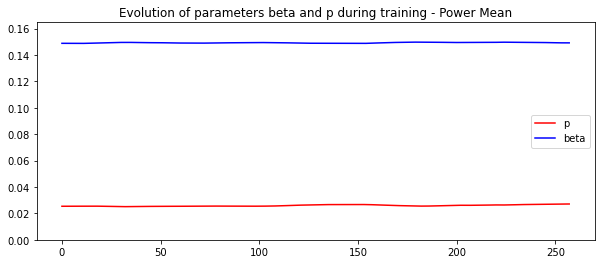

In [8]:
import matplotlib.pyplot as plt
p_epoch    = np.array([batch["p"] for batch in epoch_values]).flatten()
beta_epoch = np.array([batch["beta"] for batch in epoch_values]).flatten() 

plt.figure(figsize=(10,4))
plt.title("Evolution of parameters beta and p during training - Power Mean")
plt.plot(p_epoch, "r-", label="p")
plt.plot(beta_epoch, "b-", label="beta")
plt.ylim(0, 1.1*np.amax(np.maximum(p_epoch, beta_epoch)))
plt.legend()
plt.show()